In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dl_portfolio.data import impute_missing_risk_free, load_data, load_risk_free
from dl_portfolio.backtest import (
    get_target_vol_other_weights, 
    get_factors_rc_and_weights, 
    get_number_of_nmf_bets,
    get_number_of_pc_bets
)
import pickle
import os
import seaborn as sns
import itertools
from dl_portfolio.backtest import get_factors_rc_and_weights, get_number_of_pc_bets, get_number_of_nmf_bets


data1, asset1 = load_data("dataset1")
data2, asset2 = load_data("dataset2")

# Some useful functions

In [4]:
def load_all_backtest_result(nmf_dir, markowitz_dir, dataset):
    # Load Market budget
    if dataset == 'dataset1':
        market_budget = pd.read_csv('data/dataset1/market_budget_dataset1.csv', index_col=0)
        cryptos = ['BTC', 'DASH', 'ETH', 'LTC', 'XRP']
        market_budget = pd.concat([market_budget, pd.DataFrame(np.array([['crypto', 1]] * len(cryptos)),
                                                               index=cryptos,
                                                               columns=market_budget.columns)])
        market_budget['rc'] = market_budget['rc'].astype(int)
        market_budget.drop("CRIX", inplace=True)
    elif dataset == 'dataset2':
        market_budget = pd.read_csv('data/dataset2/market_budget_dataset2.csv', index_col=0)
        market_budget['rc'] = market_budget['rc'].astype(int)
    else:
        raise NotImplementedError()
        
    # Load markowitz and robust M results
    GMV_robust_weights = pd.read_csv(f"{markowitz_dir}/weights_GMV_robust.csv", index_col = 0)
    GMV_robust_weights.index = pd.to_datetime(GMV_robust_weights.index)
    markowitz_weights = pd.read_csv(f"{markowitz_dir}/weights_MeanVar_long.csv", index_col = 0)
    markowitz_weights.index = pd.to_datetime(markowitz_weights.index)
    
    
    port_weights = pickle.load(open(f'{nmf_dir}/portfolios_weights.p', 'rb'))
    aekeys = [c for c in port_weights.keys() if "ae" in c]
    for k in aekeys:
        key = k.replace("ae", "nmf")
        port_weights[key] = port_weights[k]
        port_weights.pop(k)
        
    port_weights["markowitz"] = markowitz_weights.loc[port_weights["rb_factor"].index]
    port_weights["GMV_robust"] = GMV_robust_weights.loc[port_weights["rb_factor"].index]


    cv_results = pd.read_pickle(f"{nmf_dir}/cv_results.p")
    
    return cv_results, port_weights, market_budget


# Save directory

In [5]:
SAVE=False
save=SAVE
savedir = "paper_result_update/nmf"
if save:
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
perf_nmf_dir_1 = "performance/test_final_models/nmf/dataset1_20230518_160622"
markowitz_dir1 = "final_models/run_11_dataset1_20230408_145352"
perf_nmf_dir_2 = "performance/test_final_models/nmf/dataset2_20230518_160843"
markowitz_dir2 = "final_models/run_12_dataset2_20230408_145946"

# Load backtest result

In [6]:
cv_results1, port_weights1, market_budget1 = load_all_backtest_result(perf_nmf_dir_1,
                                                                   markowitz_dir1,
                                                                   "dataset1")
cv_results2, port_weights2, market_budget2 = load_all_backtest_result(perf_nmf_dir_2,
                                                                   markowitz_dir2,
                                                                   "dataset2")

# Number of factors

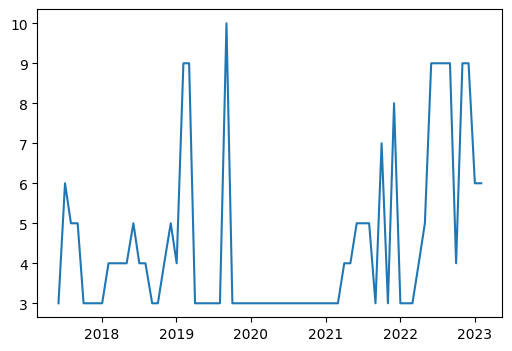

3 4.463768115942029 10


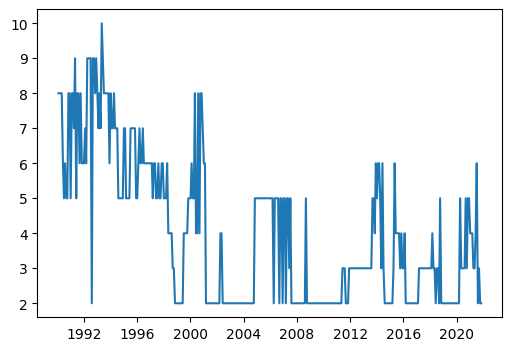

2 3.9895287958115184 10


In [7]:
save=False
assets1 = cv_results1[0][0]["loading"].index.tolist()
n_cv1 = len(cv_results1[0])
cv_dates1 = port_weights1["rb_factor"].index.tolist()
loading_shape1 = [cv_results1[0][i]["loading"].shape[-1] for i in range(n_cv1)]
plt.figure(figsize=(6,4))
plt.plot(cv_dates1, loading_shape1)
if save:
    plt.savefig(f"{savedir}/n_factors_ts_1.png", transparent=True, bbox_inches="tight")
plt.show()
print(np.min(loading_shape1), np.mean(loading_shape1), np.max(loading_shape1))

cv_results2 = pd.read_pickle(f"{perf_nmf_dir_2}/cv_results.p")
assets2 = cv_results2[0][0]["loading"].index.tolist()
n_cv2 = len(cv_results2[0])
cv_dates2 = port_weights2["rb_factor"].index.tolist()
loading_shape2 = [cv_results2[0][i]["loading"].shape[-1] for i in range(n_cv2)]
plt.figure(figsize=(6,4))
plt.plot(cv_dates2, loading_shape2)
if save:
    plt.savefig(f"{savedir}/n_factors_ts_2.png", transparent=True, bbox_inches="tight")
plt.show()
print(np.min(loading_shape2), np.mean(loading_shape2), np.max(loading_shape2))

# Example factor loadings

In [11]:
[[i, d, loading_shape1[i]] for i, d in enumerate(cv_dates1)]

[[0, Timestamp('2017-06-02 00:00:00'), 3],
 [1, Timestamp('2017-07-04 00:00:00'), 6],
 [2, Timestamp('2017-08-02 00:00:00'), 5],
 [3, Timestamp('2017-09-04 00:00:00'), 5],
 [4, Timestamp('2017-10-03 00:00:00'), 3],
 [5, Timestamp('2017-11-02 00:00:00'), 3],
 [6, Timestamp('2017-12-04 00:00:00'), 3],
 [7, Timestamp('2018-01-02 00:00:00'), 3],
 [8, Timestamp('2018-02-02 00:00:00'), 4],
 [9, Timestamp('2018-03-02 00:00:00'), 4],
 [10, Timestamp('2018-04-03 00:00:00'), 4],
 [11, Timestamp('2018-05-02 00:00:00'), 4],
 [12, Timestamp('2018-06-04 00:00:00'), 5],
 [13, Timestamp('2018-07-03 00:00:00'), 4],
 [14, Timestamp('2018-08-02 00:00:00'), 4],
 [15, Timestamp('2018-09-04 00:00:00'), 3],
 [16, Timestamp('2018-10-02 00:00:00'), 3],
 [17, Timestamp('2018-11-02 00:00:00'), 4],
 [18, Timestamp('2018-12-04 00:00:00'), 5],
 [19, Timestamp('2019-01-02 00:00:00'), 4],
 [20, Timestamp('2019-02-04 00:00:00'), 9],
 [21, Timestamp('2019-03-04 00:00:00'), 9],
 [22, Timestamp('2019-04-02 00:00:00'), 3]

2000-03-02 00:00:00


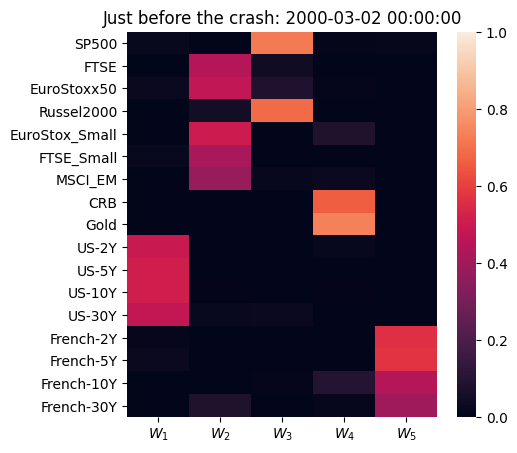

2008-01-02 00:00:00


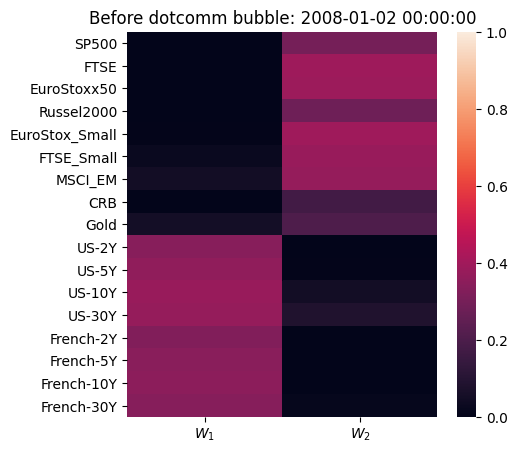

In [12]:
save=False

i = 121
date = cv_dates2[i]
print(date)
p = cv_results2[0][i]["loading"].shape[-1]
plt.figure(figsize=(5,5))
sns.heatmap(cv_results2[0][i]["loading"], vmin=0, vmax=1, 
            xticklabels=[f"$W_{i}$" for i in range(1, p+1)])
if save:
    plt.savefig(f"{savedir}/ex_loadings_before_com_crash_2.png", transparent=True, bbox_inches="tight")
plt.title(f"Just before the crash: {date}")
plt.show()

i = 215
date = cv_dates2[i]
print(date)
p = cv_results2[0][i]["loading"].shape[-1]
plt.figure(figsize=(5,5))
sns.heatmap(cv_results2[0][i]["loading"], vmin=0, vmax=1, 
            xticklabels=[f"$W_{i}$" for i in range(1, p+1)])
if save:
    plt.savefig(f"{savedir}/ex_loadings_during_2008_crisis_2.png", transparent=True, bbox_inches="tight")
plt.title(f"Before dotcomm bubble: {date}")
plt.show()


In [13]:
[[i, d, loading_shape1[i]] for i, d in enumerate(cv_dates1)]

[[0, Timestamp('2017-06-02 00:00:00'), 3],
 [1, Timestamp('2017-07-04 00:00:00'), 6],
 [2, Timestamp('2017-08-02 00:00:00'), 5],
 [3, Timestamp('2017-09-04 00:00:00'), 5],
 [4, Timestamp('2017-10-03 00:00:00'), 3],
 [5, Timestamp('2017-11-02 00:00:00'), 3],
 [6, Timestamp('2017-12-04 00:00:00'), 3],
 [7, Timestamp('2018-01-02 00:00:00'), 3],
 [8, Timestamp('2018-02-02 00:00:00'), 4],
 [9, Timestamp('2018-03-02 00:00:00'), 4],
 [10, Timestamp('2018-04-03 00:00:00'), 4],
 [11, Timestamp('2018-05-02 00:00:00'), 4],
 [12, Timestamp('2018-06-04 00:00:00'), 5],
 [13, Timestamp('2018-07-03 00:00:00'), 4],
 [14, Timestamp('2018-08-02 00:00:00'), 4],
 [15, Timestamp('2018-09-04 00:00:00'), 3],
 [16, Timestamp('2018-10-02 00:00:00'), 3],
 [17, Timestamp('2018-11-02 00:00:00'), 4],
 [18, Timestamp('2018-12-04 00:00:00'), 5],
 [19, Timestamp('2019-01-02 00:00:00'), 4],
 [20, Timestamp('2019-02-04 00:00:00'), 9],
 [21, Timestamp('2019-03-04 00:00:00'), 9],
 [22, Timestamp('2019-04-02 00:00:00'), 3]

2020-05-04 00:00:00


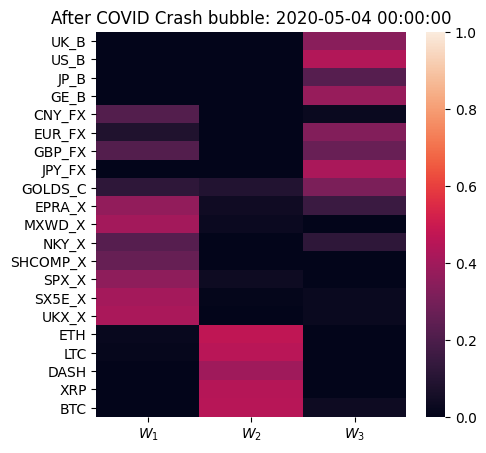

2022-06-02 00:00:00


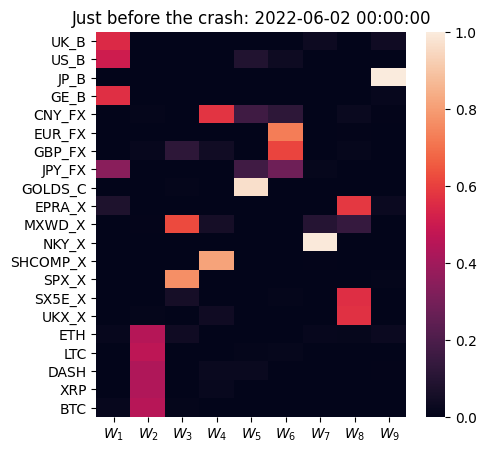

In [14]:
save=False
i = 35
date = cv_dates1[i]
print(date)
p = cv_results1[0][i]["loading"].shape[-1]
plt.figure(figsize=(5,5))
sns.heatmap(cv_results1[0][i]["loading"], vmin=0, vmax=1, 
            xticklabels=[f"$W_{i}$" for i in range(1, p+1)])
if save:
    plt.savefig(f"{savedir}/ex_loadings_covid.png", transparent=True, bbox_inches="tight")
plt.title(f"After COVID Crash bubble: {date}")
plt.show()

i = 60
date = cv_dates1[i]
print(date)
p = cv_results1[0][i]["loading"].shape[-1]
plt.figure(figsize=(5,5))
sns.heatmap(cv_results1[0][i]["loading"], vmin=0, vmax=1, 
            xticklabels=[f"$W_{i}$" for i in range(1, p+1)])
if save:
    plt.savefig(f"{savedir}/ex_loadings_end_lowrate_2022.png", transparent=True, bbox_inches="tight")
plt.title(f"Just before the crash: {date}")
plt.show()


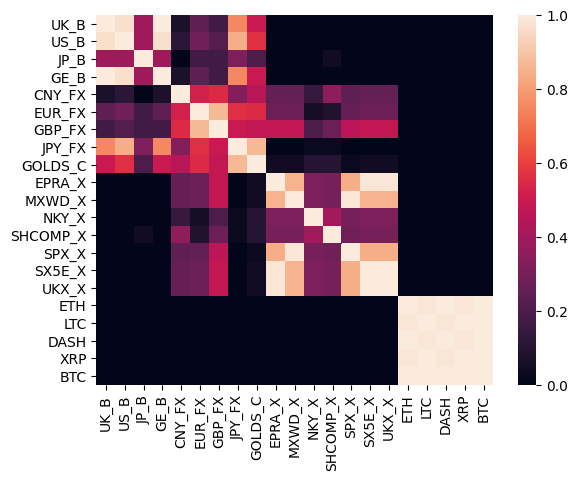

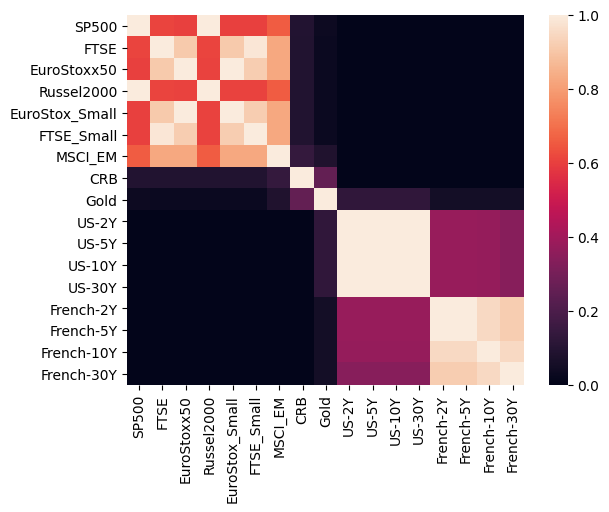

In [31]:
save=True
D = pd.DataFrame(0, index=assets1, columns=assets1)
n_cv1 = len(cv_results1[0])
clustering_res = []
for i in range(n_cv1):
    w = cv_results1[0][i]["loading"].copy() ** 2
    w[w < 0.05] = 0
    clustering_res.append((w > 0).apply(lambda x: np.array(assets1)[x].tolist(), 
                                        result_type="reduce", axis=0).to_dict())
    
for i, c_res in enumerate(clustering_res):
    for cluster in c_res.values():
        if len(cluster) > 1:
            perms = np.array(list(itertools.permutations(cluster, 2)))
            D.loc[perms[:,0], perms[:, 1]] += 1
        else:
            D.loc[cluster, cluster] += 1
D = D / n_cv1
D = D.values
D[np.diag_indices(D.shape[-1])] = 1
D = pd.DataFrame(D, index=assets1, columns=assets1)
plt.plot(figsize=(8,8))
sns.heatmap(D, vmin=0, vmax=1)
if save:
    plt.savefig(f"{savedir}/cluster_freq_1.png", transparent=True, bbox_inches="tight")
plt.show()

D = pd.DataFrame(0, index=assets2, columns=assets2)
n_cv2 = len(cv_results2[0])
clustering_res = []
for i in range(n_cv2):
    w = cv_results2[0][i]["loading"].copy() ** 2
    w[w < 0.05] = 0
    clustering_res.append((w > 0).apply(lambda x: np.array(assets2)[x].tolist(), 
                                        result_type="reduce", axis=0).to_dict())
    
for i, c_res in enumerate(clustering_res):
    for cluster in c_res.values():
        if len(cluster) > 1:
            perms = np.array(list(itertools.permutations(cluster, 2)))
            D.loc[perms[:,0], perms[:, 1]] += 1
        else:
            D.loc[cluster, cluster] += 1
D = D / n_cv2
D = D.values
D[np.diag_indices(D.shape[-1])] = 1
D = pd.DataFrame(D, index=assets2, columns=assets2)
plt.plot(figsize=(8,8))
sns.heatmap(D, vmin=0, vmax=1)
if save:
    plt.savefig(f"{savedir}/cluster_freq_2.png", transparent=True, bbox_inches="tight")
plt.show()

# Risk contribution example

2020-05-04 00:00:00


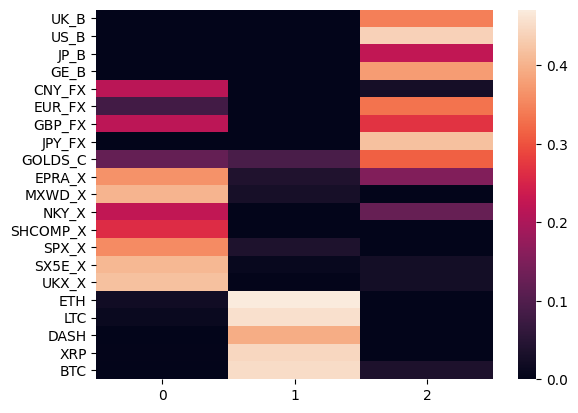

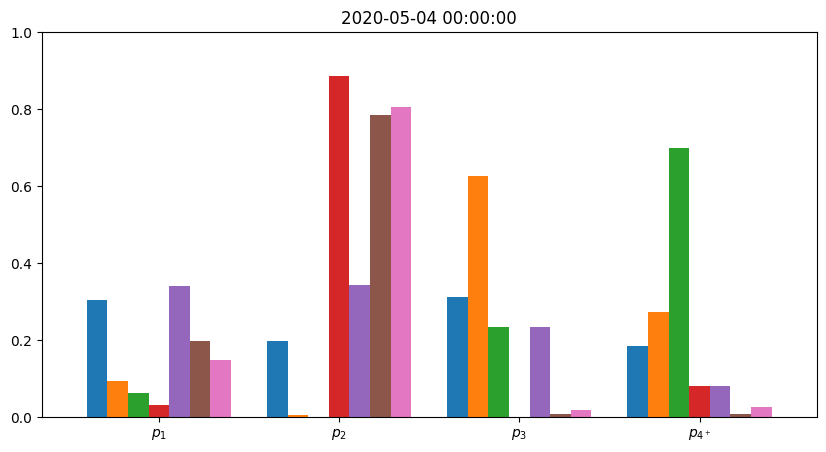

2022-06-02 00:00:00


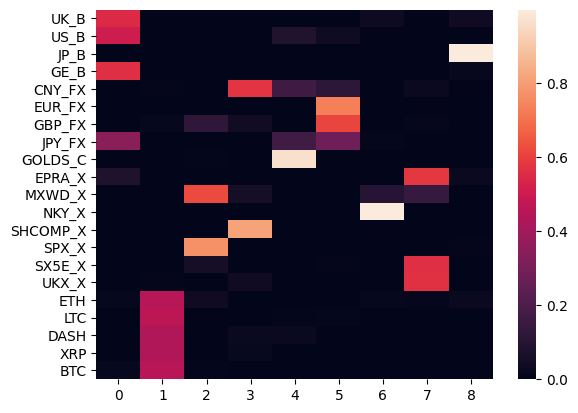

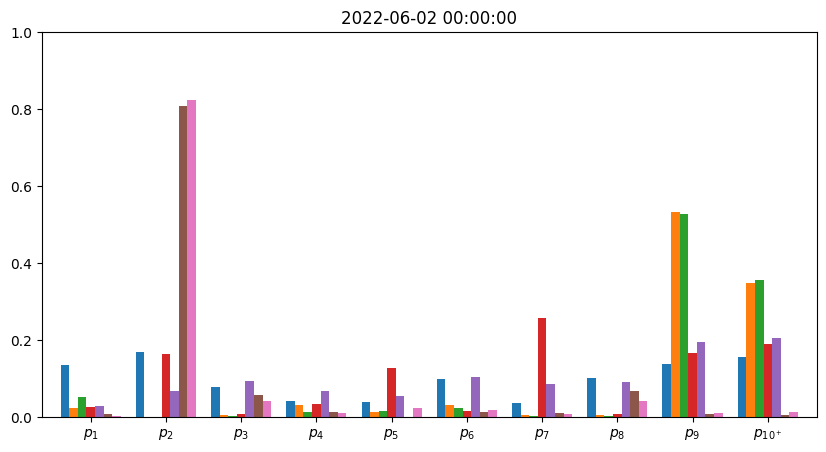

In [33]:
save=True
rc_port1, factor_w_port1 = get_factors_rc_and_weights(cv_results1, market_budget1)

i = 35
date = cv_dates1[i]
print(date)
loading = cv_results1[0][i]["loading"]
p = loading.shape[-1]

sns.heatmap(loading)
plt.show()

rcs = []
for port in rc_port1:
    rc = rc_port1[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rc = np.concatenate([rc[:p], [np.sum(rc[p:])]])
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rc_port1.keys()).drop("rb_factor_full_erc", axis=1)

rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, 4)] + ["$p_{4^+}$"], rotation=0)

plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_covid.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()

i = 60
date = cv_dates1[i]
print(date)
loading = cv_results1[0][i]["loading"]
p = loading.shape[-1]

sns.heatmap(loading)
plt.show()

rcs = []
for port in rc_port1:
    rc = rc_port1[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rc = np.concatenate([rc[:p], [np.sum(rc[p:])]])
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rc_port1.keys()).drop("rb_factor_full_erc", axis=1)
rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, 10)] + ["$p_{10^+}$"], rotation=0)
plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_end_lowrate_2022.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()


2000-03-02 00:00:00
5


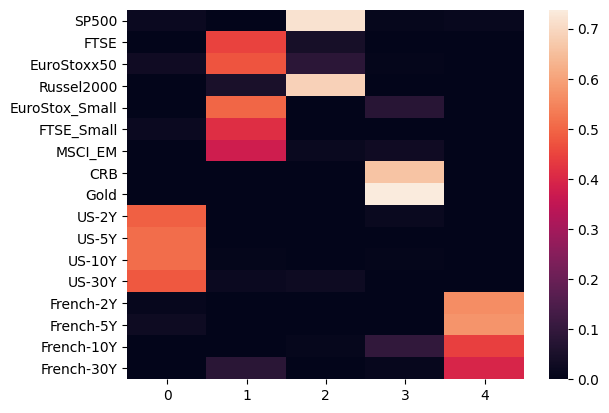

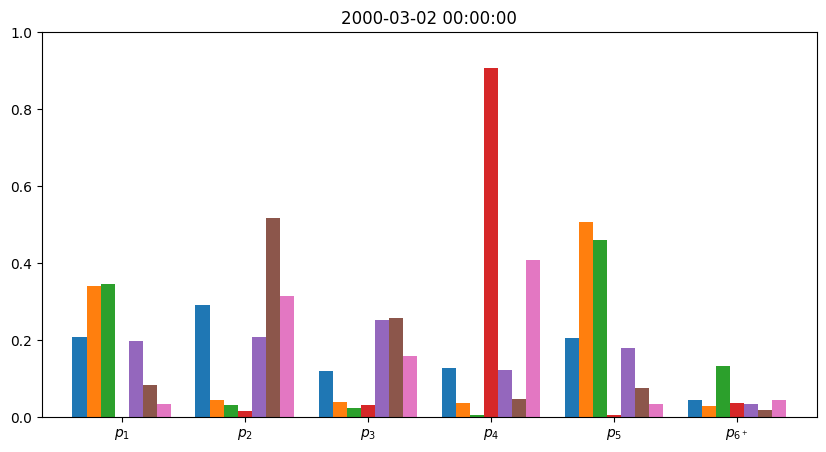

2008-01-02 00:00:00
2


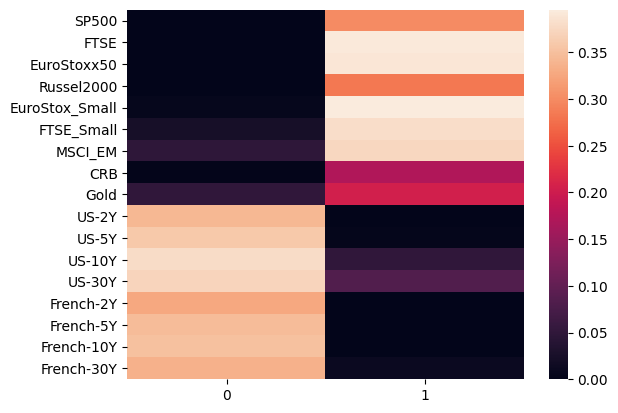

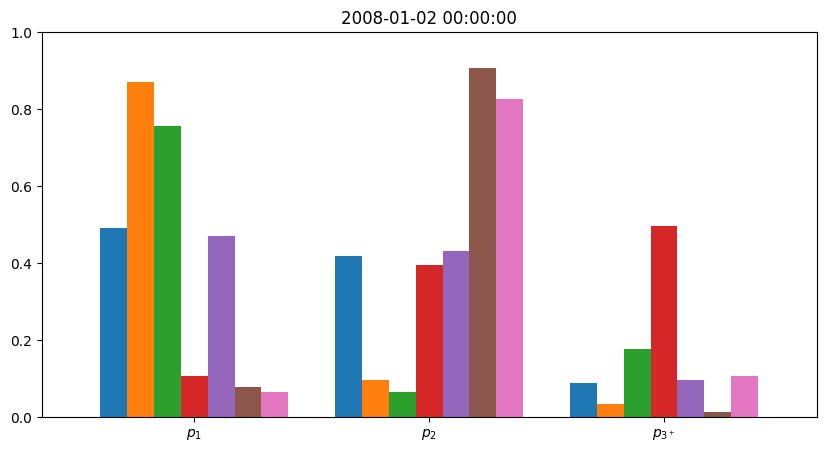

In [34]:
save=True
rc_port2, factor_w_port2 = get_factors_rc_and_weights(cv_results2, market_budget2)

i = 121
date = cv_dates2[i]
print(date)
loading = cv_results2[0][i]["loading"]
p = loading.shape[-1]
print(p)
sns.heatmap(loading)
plt.show()

rcs = []
for port in rc_port2:
    rc = rc_port2[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rc = np.concatenate([rc[:p], [np.sum(rc[p:])]])
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rc_port2.keys()).drop("rb_factor_full_erc", axis=1)

rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, 6)] + ["$p_{6^+}$"], rotation=0)

plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_before_com_crash_2.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()

i = 215
date = cv_dates2[i]
print(date)
loading = cv_results2[0][i]["loading"]
p = loading.shape[-1]
print(p)

sns.heatmap(loading)
plt.show()



rcs = []
for port in rc_port2:
    rc = rc_port2[port][0].iloc[i]
    rc = rc.abs()/rc.abs().sum()
    rc = np.concatenate([rc[:p], [np.sum(rc[p:])]])
    rcs.append(rc)
rcs = np.array(rcs)
rcs = pd.DataFrame(rcs.T, columns=rc_port2.keys()).drop("rb_factor_full_erc", axis=1)
rcs.plot(kind='bar', legend=not save,  figsize=(10,5), width=0.8)
_ = plt.xticks(range(p+1), [f"$p_{i}$" for i in range(1, 3)] + ["$p_{3^+}$"], rotation=0)
plt.ylim(0,1)
if save:
    plt.savefig(f"{savedir}/rcs_during_2008_crisis_2.png", transparent=True, bbox_inches="tight")
plt.title(date)
plt.show()


# Number of bets over time

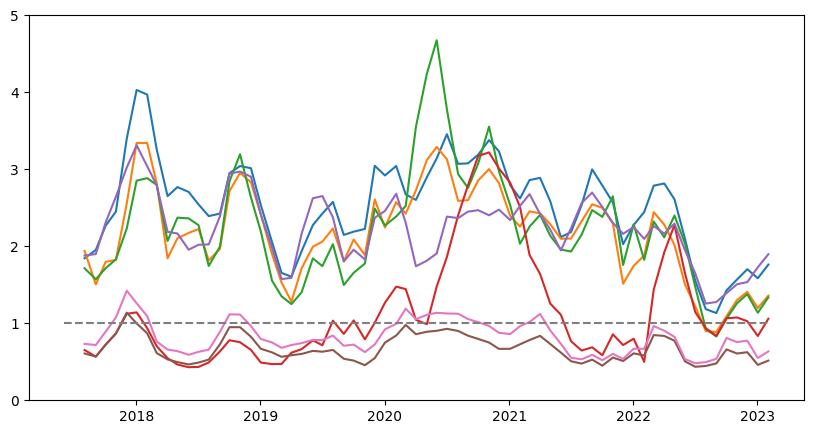

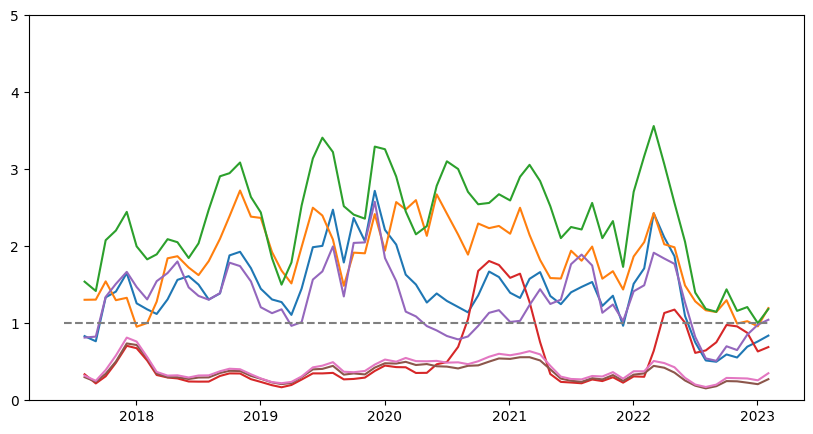

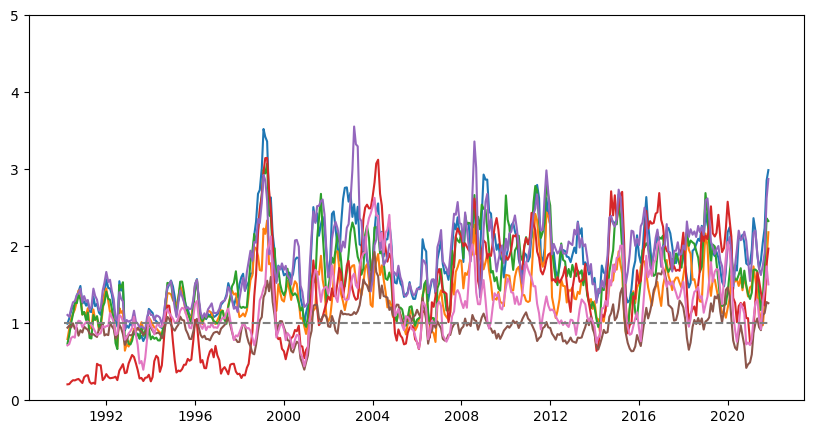

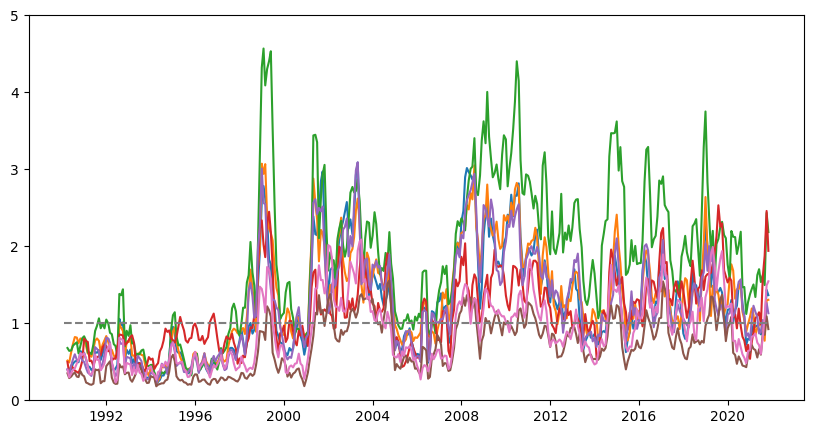

In [107]:
save=True
nmf_bets = get_number_of_nmf_bets(rc_port1).drop("rb_factor_full_erc", axis=1)
nmf_bets.index = cv_dates1

plt.figure(figsize=(10,5))
plt.plot((nmf_bets/pd.Series(loading_shape1, index=cv_dates1).values.reshape(-1,1)).rolling(3).mean())
plt.plot(cv_dates1, [1] * len(cv_dates1), '--')
plt.ylim(0, 5)
if save:
    plt.savefig(f"{savedir}/nmf_bets_ts_1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(nmf_bets.columns)

pc_bets = get_number_of_pc_bets(cv_results1, market_budget1.drop("CRIX")).drop("rb_factor_full_erc", axis=1)
pc_bets.index = cv_dates1

plt.figure(figsize=(10,5))
plt.plot((pc_bets/pd.Series(loading_shape1, index=cv_dates1).values.reshape(-1,1)).rolling(3).mean())
plt.ylim(0, 5)
plt.plot(cv_dates1, [1] * len(cv_dates1), '--')
if save:
    plt.savefig(f"{savedir}/pc_bets_ts_1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(pc_bets.columns)
plt.show()

nmf_bets = get_number_of_nmf_bets(rc_port2).drop("rb_factor_full_erc", axis=1)
nmf_bets.index = cv_dates2

plt.figure(figsize=(10,5))
plt.plot((nmf_bets/pd.Series(loading_shape2, index=cv_dates2).values.reshape(-1,1)).rolling(3).mean())
plt.plot(cv_dates2, [1] * len(cv_dates2), '--')
plt.ylim(0, 5)
if save:
    plt.savefig(f"{savedir}/nmf_bets_ts_2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(nmf_bets.columns)

pc_bets = get_number_of_pc_bets(cv_results2, market_budget2).drop("rb_factor_full_erc", axis=1)
pc_bets.index = cv_dates2

plt.figure(figsize=(10,5))
plt.plot((pc_bets/pd.Series(loading_shape2, index=cv_dates2).values.reshape(-1,1)).rolling(3).mean())
plt.plot(cv_dates2, [1] * len(cv_dates2), '--')
plt.ylim(0, 5)
if save:
    plt.savefig(f"{savedir}/pc_bets_ts_2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(pc_bets.columns)
plt.show()

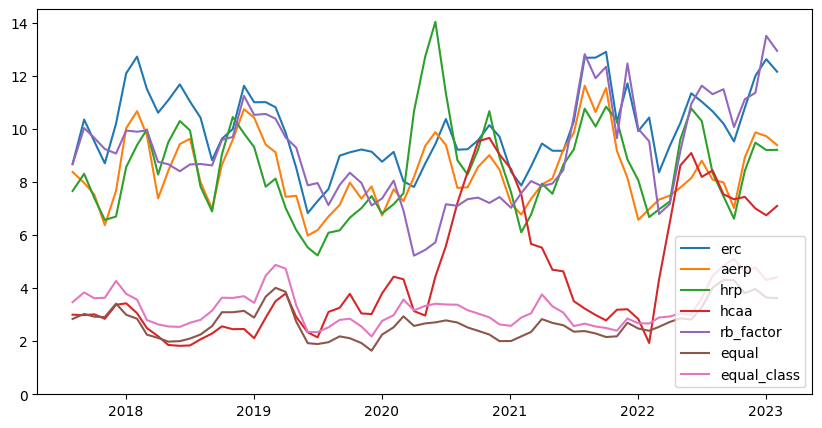

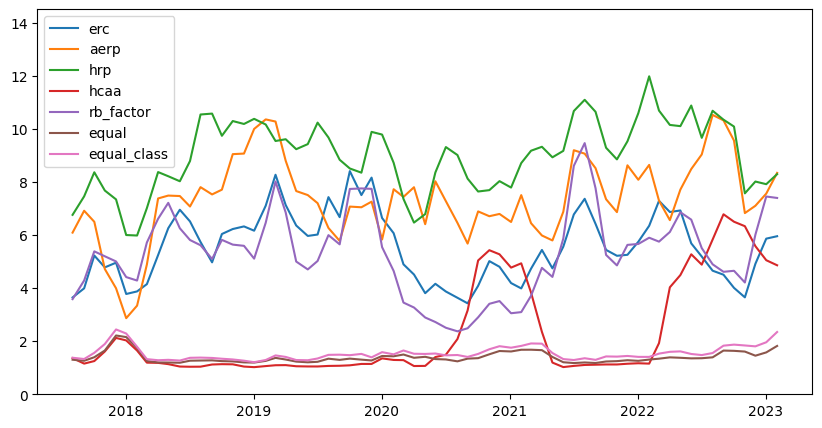

In [119]:
save=False
nmf_bets = get_number_of_nmf_bets(rc_port1).drop("rb_factor_full_erc", axis=1)
nmf_bets.index = cv_dates1

plt.figure(figsize=(10,5))
plt.plot(nmf_bets.rolling(3).mean())
plt.ylim(0, 14.5)
if save:
    plt.savefig(f"{savedir}/nmf_bets_ts_1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(nmf_bets.columns)

pc_bets = get_number_of_pc_bets(cv_results1, market_budget1.drop("CRIX")).drop("rb_factor_full_erc", axis=1)
pc_bets.index = cv_dates1

plt.figure(figsize=(10,5))
plt.plot(pc_bets.rolling(3).mean())
plt.ylim(0, 14.5)
if save:
    plt.savefig(f"{savedir}/pc_bets_ts_1.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(pc_bets.columns)
plt.show()


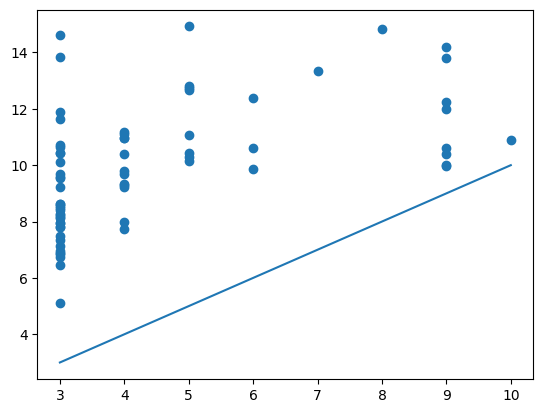

In [128]:
plt.scatter(loading_shape1, nmf_bets["erc"])
plt.plot([min(loading_shape1), max(loading_shape1)], [min(loading_shape1), max(loading_shape1)])

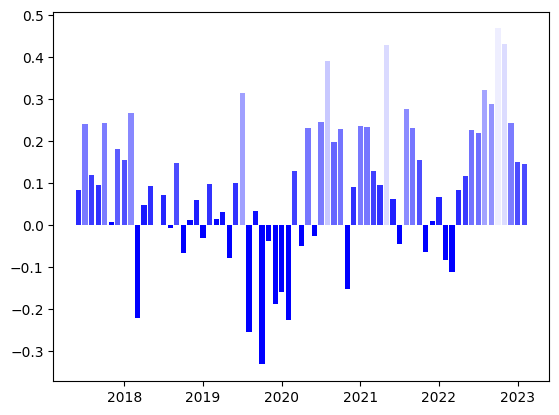

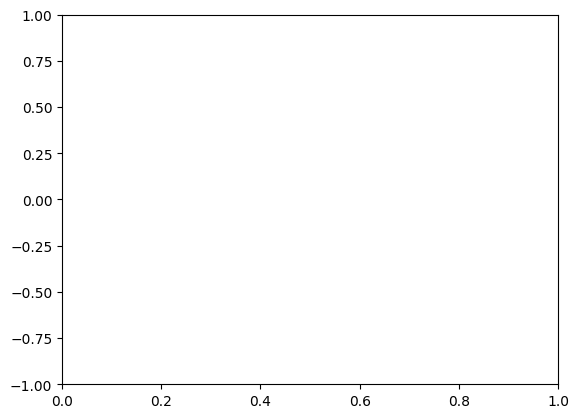

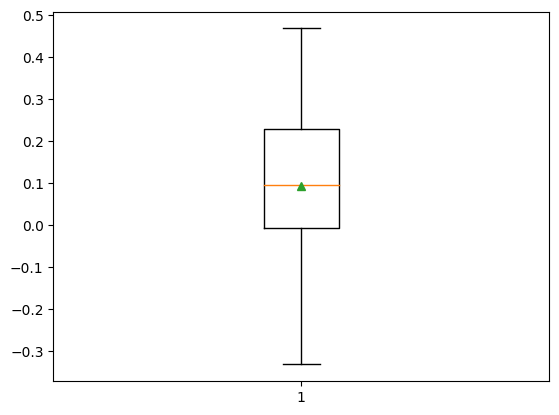

In [202]:
import matplotlib.dates as mdate
my_cmap = plt.get_cmap("bwr")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
avg_cv_corr = [
    np.mean(
        cv_results1[0][i]["test_features"].corr().values[
            np.triu_indices(cv_results1[0][i]["test_features"].shape[-1], k = 1)
        ]
    ) for i in range(n_cv1)
]
plt.bar(range(n_cv1), avg_cv_corr, color=my_cmap(rescale(avg_cv_corr)))
_ = plt.xticks([i for i, d in enumerate(cv_dates1) if d.month == 1],
               [d.strftime("%Y") for d in cv_dates1 if d.month == 1])
plt.show()

plt.ylim(-1, 1)
plt.show()
plt.boxplot(avg_cv_corr, showmeans=True)
plt.show()

In [200]:
plt.bar(range(n_cv1), avg_cv_corr, color=my_cmap(rescale(avg_cv_corr)))


array([0.51784082, 0.71553024, 0.56413344, 0.53481051, 0.71983583,
       0.42255718, 0.64147449, 0.60981618, 0.74718141, 0.13897144,
       0.47535843, 0.53139072, 0.41525764, 0.50445323, 0.40676228,
       0.60083997, 0.33079796, 0.43047732, 0.49017822, 0.37747473,
       0.53761319, 0.43314251, 0.45325393, 0.31543512, 0.54101069,
       0.8070397 , 0.09754582, 0.45560618, 0.        , 0.36670632,
       0.18039631, 0.21649336, 0.13364704, 0.57505171, 0.35140014,
       0.70455018, 0.38272903, 0.72191632, 0.9045763 , 0.66349241,
       0.70104704, 0.22439037, 0.52838834, 0.70917135, 0.70546796,
       0.57562548, 0.53343841, 0.94964075, 0.49397058, 0.35728457,
       0.76002135, 0.70487934, 0.60737256, 0.33597721, 0.4278531 ,
       0.49929183, 0.31236419, 0.27526762, 0.51966195, 0.56108239,
       0.69675421, 0.68770501, 0.81702942, 0.77459148, 1.        ,
       0.95423116, 0.71993446, 0.60265543, 0.59681224])

In [309]:
from scipy.linalg import sqrtm

def EffectiveBets(w, Sigma, t):
    Sigma = np.asmatrix(Sigma)
    w = np.asmatrix(w)
    p = np.asmatrix(np.asarray(np.linalg.inv(t.T) * w.T) * np.asarray(t * Sigma * w.T)) / (w * Sigma * w.T)
    print(p)
    enb = np.exp(- p.T * np.log(p + 1e-6))
    return p, enb
"""
n_ <- ncol(sigma)

      ## initialize
      d <- rep(1, n_)
      f <- rep(0, max_niter)

      for (i in 1:max_niter) {
        U <- diag(d) %*% c %*% c %*% diag(d)
        u <- sqrtm(U)
        q <- solve(u) %*% (diag(d) %*% c)
        d <- diag(q %*% c)
        pi_ <- diag(d) %*% q ## perturbation
        f[i] <- norm(c - pi_, 'F')

        if (i > 1 && abs(f[i] - f[i - 1]) / f[i] / n_ <= 10 ^ -8) {

          f <- f[1:i]

          break

        } else if (i == max_niter && abs(f[max_niter] - f[max_niter - 1]) / f[max_niter] / n_ > 10 ^ -8) {
"""
def torsion(Sigma, model, method='exact', max_niter=10000):
    Sigma = np.asmatrix(Sigma)
    n = Sigma.shape[0]    
    if model == 'pca':
        eigval, eigvec = np.linalg.eig(Sigma)
        idx = np.argsort(-eigval)
        t = eigvec[:,idx]
    elif model == 'minimum-torsion':
        # C: correlation matrix
        sigma = np.sqrt(np.diag(Sigma))
        C = np.asmatrix(np.diag(1.0/sigma)) * np.asmatrix(Sigma) * np.asmatrix(np.diag(1.0/sigma))
        # Riccati root of correlation matrix
        c = sqrtm(C)
        if method == 'approximate':
            t = (np.asmatrix(sigma) / np.asmatrix(c)) * np.asmatrix(np.diag(1.0/sigma))
        elif method == 'exact':
            # initialize
            d = np.ones((n))
            f = np.zeros((max_niter))
            # iterating
            for i in range(max_niter):
                U = np.asmatrix(np.diag(d)) * c * c * np.asmatrix(np.diag(d))
                u = sqrtm(U)
                q = np.linalg.inv(u) * np.asmatrix(np.diag(d)) * c
                d = np.diag(q * c)
                pi = np.asmatrix(np.diag(d)) * q
                f[i] = np.linalg.norm(c - pi, 'fro')
                # if converge
                if i > 0 and abs(f[i]-f[i-1])/f[i] <= 1e-4:
                    f = f[0:i]
                    break
                elif i == max_niter and abs(f[max_niter]-f[max_niter-1])/f[max_niter] >= 1e-4:
                    print('number of max iterations reached: n_iter = ' + str(max_niter))
            x = pi * np.linalg.inv(np.asmatrix(c))
            t = np.asmatrix(np.diag(sigma)) * x * np.asmatrix(np.diag(1.0/sigma))
    return t

In [427]:
import pandas as pd

PORTFOLIOS = list(cv_results1[0][0]["port"].keys()) + ["equal"]
pc_bets1_new = {p: [] for p in PORTFOLIOS}
mt_bets1 = {p: [] for p in PORTFOLIOS}

rc_mt = {p: [] for p in PORTFOLIOS}

for t in range(len(cv_results1[0])):
    print(len(cv_results1[0])-t)
    Sigma = np.cov(cv_results1[0][t]["train_returns"].T)
    t_pc = torsion(Sigma, 'pca')
    t_mt = torsion(Sigma, 'minimum-torsion',  method='exact')
    for p in PORTFOLIOS:
        if p == "equal":
            w = np.array([1/len(assets1)] * len(assets1))
        else:
            w = cv_results1[0][t]["port"][p].values
            
        pc_bets1_new[p].append(np.real(np.array(EffectiveBets(w, Sigma, t_pc)[1])[0,0]))
        
        rc_i, nb = EffectiveBets(w, Sigma, t_mt)
        nb = np.real(np.array(nb)[0,0])
        mt_bets1[p].append(nb)
        rc_mt[p].append(np.real(np.asarray(rc_i)[:,0]))
pc_bets1_new = pd.DataFrame(pc_bets1_new, index=cv_dates1)
mt_bets1 = pd.DataFrame(mt_bets1, index=cv_dates1)


69
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 19]
[[ 5.26832131e-02]
 [ 2.94055292e-01]
 [ 5.24337804e-02]
 [-9.31243699e-02]
 [ 4.70176119e-02]
 [-2.05258034e-03]
 [ 1.34521723e-01]
 [ 1.04778751e-02]
 [-1.21687500e-04]
 [ 5.89836321e-03]
 [ 1.22270992e-01]
 [ 8.35409280e-02]
 [ 2.17115387e-02]
 [-9.48644778e-02]
 [ 1.72170378e-01]
 [-1.81982163e-02]
 [ 1.77281535e-01]
 [ 4.58144334e-03]
 [ 6.46522769e-04]
 [-1.93112742e-04]
 [ 2.92632471e-02]]
[[0.04931861]
 [0.05137659]
 [0.04432179]
 [0.0444542 ]
 [0.06319248]
 [0.06070714]
 [0.04241888]
 [0.03802721]
 [0.04497064]
 [0.06567811]
 [0.04175275]
 [0.04244751]
 [0.04375097]
 [0.04493396]
 [0.0397848 ]
 [0.04127489]
 [0.04961317]
 [0.04653468]
 [0.04633887]
 [0.04731814]
 [0.05178461]]
[[ 1.94072259e-02]
 [ 7.42168982e-02]
 [-9.53918249e-03]
 [-1.25939673e-02]
 [ 8.42066444e-03]
 [ 3.09996670e-03]
 [ 1.16185098e-01]
 [ 2.57627970e-02]
 [ 3.70838885e-02]
 [ 7.28157370e-04]
 [ 4.58043491e-03]
 [ 1.12487228e-01]
 [ 1.4675

/var/folders/42/lvxjy6497p5cc815gnmf33tm0000gn/T/ipykernel_13426/1670824573.py:8: RuntimeWarning: invalid value encountered in log
  enb = np.exp(- p.T * np.log(p + 1e-6))


[[ 0.33578992]
 [-0.01448677]
 [ 0.06096768]
 [ 0.07812637]
 [ 0.25526102]
 [ 0.12997561]
 [-0.08402906]
 [ 0.00493276]
 [ 0.00639323]
 [-0.00540666]
 [ 0.18262142]
 [-0.00427774]
 [ 0.00072882]
 [ 0.04965934]
 [ 0.01176826]
 [-0.01964535]
 [ 0.0140089 ]
 [ 0.00319115]
 [ 0.00540364]
 [-0.01297761]
 [ 0.00199506]]
[[3.90669274e-04]
 [4.21786267e-05]
 [5.95518101e-05]
 [1.24955180e-05]
 [2.12053615e-04]
 [2.62516067e-03]
 [2.85494624e-03]
 [2.31190963e-03]
 [3.15150892e-03]
 [3.50010285e-03]
 [8.93664575e-05]
 [6.07923984e-03]
 [8.18885083e-03]
 [3.71631253e-04]
 [8.49921053e-04]
 [2.39851855e-03]
 [1.87724641e-01]
 [2.15877894e-01]
 [2.03869650e-01]
 [1.84324783e-01]
 [1.75064927e-01]]
[[-0.10504586]
 [-0.0442485 ]
 [ 0.011799  ]
 [ 0.34429144]
 [ 0.4012054 ]
 [-0.13838829]
 [-0.06026668]
 [ 0.19957681]
 [ 0.07882977]
 [-0.00724149]
 [-0.13511194]
 [ 0.03273148]
 [ 0.05624183]
 [ 0.32948088]
 [ 0.02358376]
 [-0.06518631]
 [-0.00527412]
 [ 0.04854822]
 [-0.00119916]
 [ 0.04769739]
 [-0.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 18]
[[ 0.05209183]
 [ 0.29429199]
 [ 0.00830348]
 [-0.00657131]
 [-0.0468684 ]
 [ 0.14887333]
 [-0.16286019]
 [ 0.05423182]
 [-0.02727519]
 [ 0.23845202]
 [ 0.75923867]
 [-0.07891576]
 [ 0.1176341 ]
 [-0.26902694]
 [-0.12884637]
 [-0.06545467]
 [ 0.09607291]
 [ 0.20816518]
 [-0.10184934]
 [-0.0100344 ]
 [-0.07965277]]
[[0.05927836]
 [0.04166189]
 [0.04476542]
 [0.04358603]
 [0.0581705 ]
 [0.04797644]
 [0.05739251]
 [0.04697411]
 [0.05309578]
 [0.06315201]
 [0.03377315]
 [0.04971359]
 [0.0390938 ]
 [0.04511464]
 [0.04234888]
 [0.03315295]
 [0.05415216]
 [0.04770634]
 [0.05205483]
 [0.05015213]
 [0.03668447]]
[[ 0.00606856]
 [ 0.07060405]
 [ 0.00135274]
 [-0.00841771]
 [-0.00174126]
 [ 0.02810465]
 [ 0.00200698]
 [-0.02738338]
 [-0.02914651]
 [ 0.08924676]
 [ 0.2201885 ]
 [-0.00841635]
 [ 0.00321321]
 [ 0.22756285]
 [-0.05246183]
 [-0.01877844]
 [ 0.10023998]
 [ 0.4646322 ]
 [-0.15138591]
 [ 0.064759  ]
 [ 0.01975192]]
[[1.6334

In [428]:
mt_bets1

erc       aerp       hrp       hcaa  rb_factor  \
2017-06-02  20.767578  10.217438  7.334971   2.196856  16.935285   
2017-07-04  20.817880  12.718898  7.739905   2.337751  19.162125   
2017-08-02  20.800506  11.935066  8.518512   2.292393  18.567023   
2017-09-04  20.795064   9.944961  7.957525   2.385756  18.409360   
2017-10-03  20.773663  14.641951  7.922402   2.802374  17.030083   
...               ...        ...       ...        ...        ...   
2022-10-02  20.861014  12.223374  3.627302   5.510156  19.057781   
2022-11-02  20.870839   5.753152  3.590165   6.066159  19.029279   
2022-12-02  20.854229   5.879941  4.023828  10.005964  19.052181   
2023-01-02  20.851411   4.460611  4.532397  10.938982  19.734409   
2023-02-02  20.860995   5.802989  5.596294  16.531911  20.065743   

            rb_factor_full_erc      equal  
2017-06-02           17.717997   6.290988  
2017-07-04           19.046936   5.998394  
2017-08-02           18.931047   5.969517  
2017-09-04           18.825699   5.965929  
2017-10-03           17.404901   5.779055  
...                        ...        ...  
2022-10-02           19.357877  10.559819  
2022-11-02           19.099186  11.494034  
2022-12-02           19.312275  12.161898  
2023-01-02           18.697588  12.345077  
2023-02-02           18.721150  13.114963  

[69 rows x 7 columns]

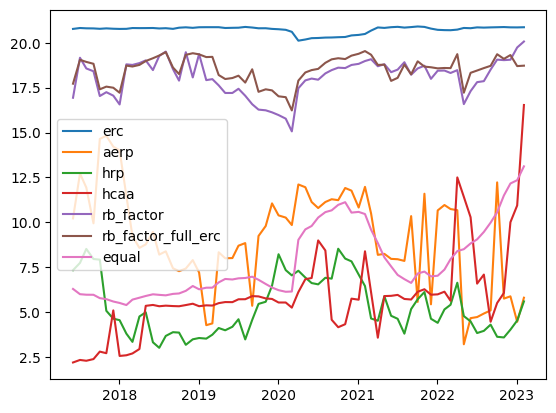

In [429]:
plt.plot(mt_bets1)
plt.legend(PORTFOLIOS)
plt.show()

Text(0.5, 1.0, 'erc')

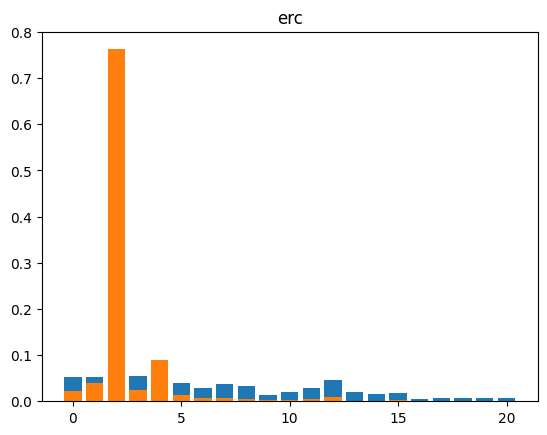

In [327]:
w = cv_results1[0][t]["port"]["erc"].values
plt.bar(range(21), w)
plt.title("erc")
w = cv_results1[0][t]["port"]["hrp"].values

plt.bar(range(21), w)
plt.title("erc")


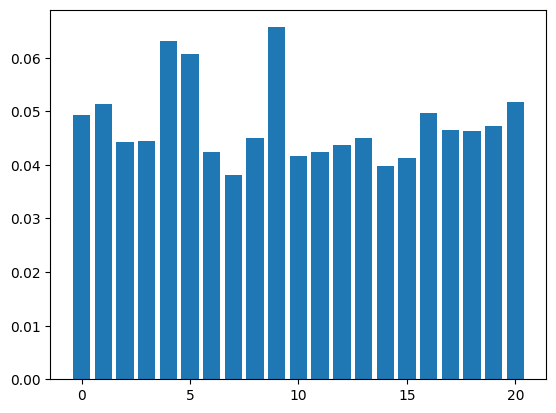

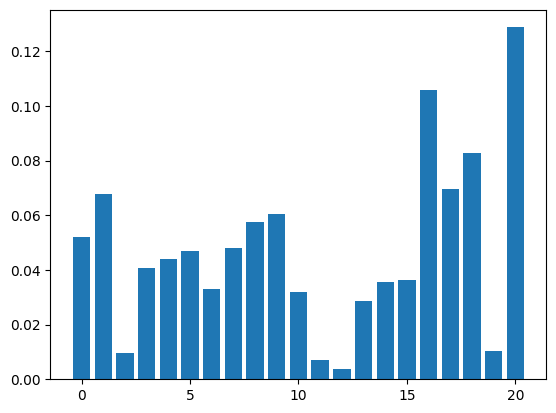

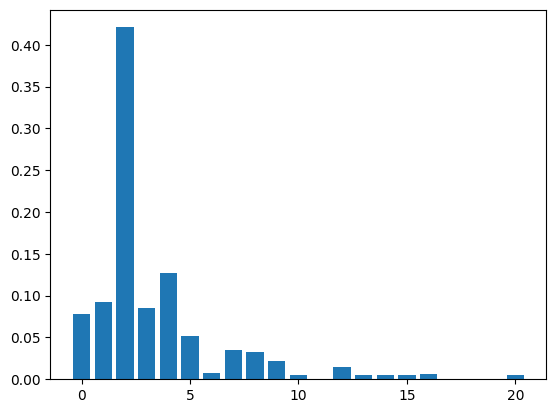

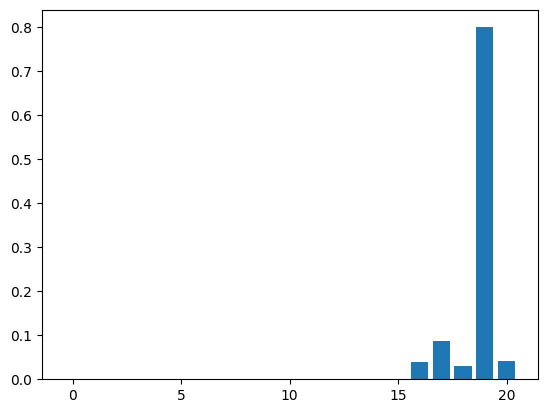

In [323]:
for p in rc_mt:
    rc_mt[p] = pd.DataFrame(rc_mt[p], index=cv_dates1)
    
plt.bar(range(21), rc_mt["erc"].iloc[0])
plt.show()
plt.bar(range(21), rc_mt["rb_factor"].iloc[0])
plt.show()
plt.bar(range(21), rc_mt["hrp"].iloc[0])
plt.show()
plt.bar(range(21), rc_mt["hcaa"].iloc[0])
plt.show()

# Min torsion bets factors

In [ ]:
import pandas as pd

PORTFOLIOS = list(cv_results1[0][0]["port"].keys())
pc_bets1_new = {p: [] for p in PORTFOLIOS}
mt_bets1 = {p: [] for p in PORTFOLIOS}

rc_mt = {p: [] for p in PORTFOLIOS}

for t in range(len(cv_results1[0])):
    print(len(cv_results1[0])-t)
    Sigma = np.cov(cv_results1[0][t]["train_returns"].T)
    t_pc = torsion(Sigma, 'pca')
    t_mt = torsion(Sigma, 'minimum-torsion',  method='exact')
    for p in PORTFOLIOS:
        w = cv_results1[0][t]["port"][p].values
        pc_bets1_new[p].append(np.real(np.array(EffectiveBets(w, Sigma, t_pc)[1])[0,0]))
        
        rc_i, nb = EffectiveBets(w, Sigma, t_mt)
        nb = np.real(np.array(nb)[0,0])
        mt_bets1[p].append(nb)
        rc_mt[p].append(np.real(np.asarray(rc_i)[:,0]))
pc_bets1_new = pd.DataFrame(pc_bets1_new, index=cv_dates1)
mt_bets1 = pd.DataFrame(mt_bets1, index=cv_dates1)


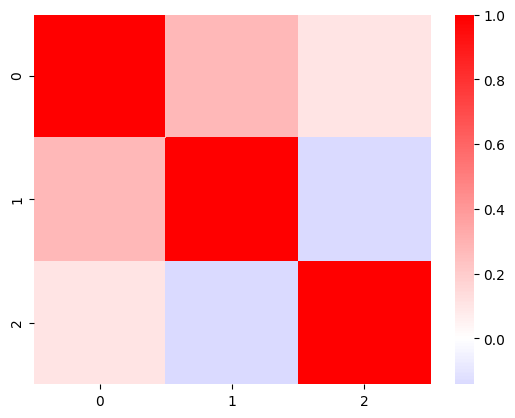

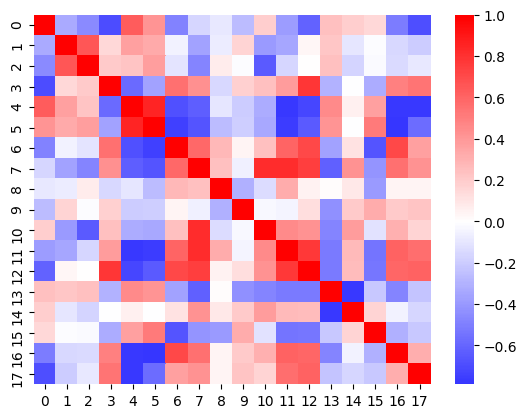

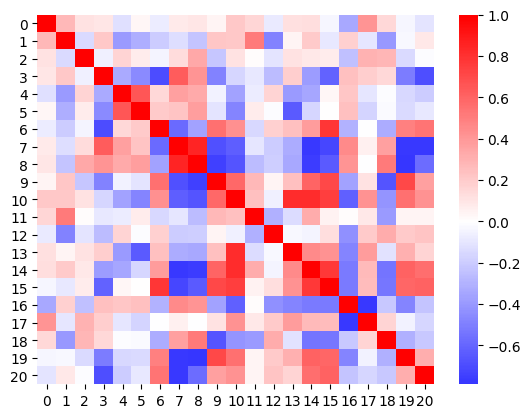

In [373]:
W_tilde = np.dot(np.diag(cv_results1[0][0]["scaler"]["attributes"]["scale_"]), cv_results1[0][0]["loading"])

ret = cv_results1[0][0]["returns"].values
factors = cv_results1[0][0]["test_features"].values
sns.heatmap(np.corrcoef(factors.T), cmap="bwr", center=0)
plt.show()
V = W_tilde.T
V_tilde = scipy.linalg.null_space(V).T
res_factors = np.dot(np.linalg.pinv(V_tilde).T, ret.T).T
sns.heatmap(np.corrcoef(res_factors.T), cmap="bwr", center=0)
plt.show()

all_factors = np.concatenate([factors, res_factors], axis=1)
sns.heatmap(np.corrcoef(all_factors.T), cmap="bwr", center=0)

69
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[[ 0.64448367]
 [-0.00642672]
 [ 0.20837493]
 [ 0.55296557]
 [-0.19543142]
 [ 0.03018442]
 [-0.05283489]
 [-0.09731134]
 [-0.06185978]
 [ 0.10382068]
 [ 0.00536252]
 [-0.01132168]
 [ 0.12234494]
 [-0.23831067]
 [-0.24990441]
 [ 0.1440625 ]
 [ 1.15567513]
 [-0.616105  ]
 [-0.0250792 ]
 [-0.22674559]
 [-0.18594366]]
[[1.73656683e-01-4.58620141e-10j]
 [1.23762335e-01-2.10438886e-10j]
 [2.93746949e-01-2.09500520e-10j]
 [3.07647070e-02+6.48851889e-10j]
 [6.03945512e-06-2.99666117e-13j]
 [4.66910205e-03-3.35287058e-11j]
 [3.42472609e-02-1.19061873e-10j]
 [6.94063122e-03-2.31179998e-11j]
 [2.05776508e-02+1.95867421e-10j]
 [8.69479635e-03-4.06504191e-11j]
 [2.03911988e-05-2.49260596e-10j]
 [2.30923696e-02-2.20607420e-10j]
 [2.79314026e-02+1.76972165e-11j]
 [7.57293058e-03-2.92325290e-10j]
 [5.00953512e-04-4.27573245e-11j]
 [7.80311587e-04+1.52190581e-10j]
 [2.57021295e-06-2.69542781e-10j]
 [1.24362297e-01+5.46951184e-09j]
 [2.

/var/folders/42/lvxjy6497p5cc815gnmf33tm0000gn/T/ipykernel_13426/1670824573.py:8: RuntimeWarning: invalid value encountered in log
  enb = np.exp(- p.T * np.log(p + 1e-6))


[[ 2.01962555e-01]
 [ 1.18894049e-01]
 [ 2.26844244e-01]
 [-2.15327070e-01]
 [-6.37758310e-02]
 [ 4.69744893e-02]
 [ 1.84955766e-04]
 [ 2.45195767e-01]
 [ 3.80840021e-01]
 [ 4.21229120e-02]
 [ 1.29013379e-02]
 [-2.18043546e-03]
 [-3.61068606e-01]
 [-3.42166234e-02]
 [ 3.50383654e-01]
 [ 1.24053061e-01]
 [-2.45883917e-01]
 [-2.99790169e-01]
 [ 3.16078086e-01]
 [-2.68685278e-01]
 [ 4.24492796e-01]]
[[1.57690141e-01+2.81389769e-09j]
 [1.57259213e-01-1.00932586e-08j]
 [2.79625616e-02+2.23748573e-09j]
 [8.14269434e-02+2.41602222e-09j]
 [1.33303438e-02-6.48505298e-10j]
 [3.00119562e-03+2.12862147e-09j]
 [1.44968064e-03-4.44204341e-10j]
 [2.95047867e-02+2.11055931e-09j]
 [7.76659646e-03-3.42785778e-09j]
 [2.07431783e-02+6.46095250e-10j]
 [2.94572732e-04+4.56825842e-10j]
 [1.34970846e-02+3.35895096e-10j]
 [3.94181506e-02-1.33205046e-09j]
 [2.39028010e-09-4.98136928e-09j]
 [2.17116415e-01+4.39346659e-09j]
 [6.81366163e-02-6.71568898e-10j]
 [5.28550090e-03+2.11122766e-08j]
 [1.75667056e-10+5.036

[[-0.01563992+0.0097374j ]
 [ 0.62157739+0.00177828j]
 [ 0.17800127+0.01113637j]
 [-0.05450906+0.01985679j]
 [-0.12293866+0.17090033j]
 [-0.29276446+0.00319961j]
 [-0.14049309+0.01656931j]
 [ 0.00231835+0.03158121j]
 [-0.00138228-0.00931848j]
 [-0.09779287+0.0368445j ]
 [ 0.03714019+0.02779982j]
 [-0.15919798-0.06856319j]
 [ 0.06878635-0.05532504j]
 [-0.05988623-0.04956221j]
 [-0.05105705+0.0645722j ]
 [ 0.09873132-0.03818465j]
 [ 0.23164254-0.13518763j]
 [-0.03483915-0.00274092j]
 [ 0.58722462-0.08724238j]
 [ 0.14104691+0.04175122j]
 [ 0.06403177+0.01039744j]]
[[1.45499164e-01-3.61435246e-10j]
 [2.39316685e-01+8.28111421e-10j]
 [1.52825783e-01-1.25827448e-09j]
 [1.15523515e-01-4.05285991e-10j]
 [1.94890866e-02-5.70683292e-10j]
 [1.88245683e-03-1.33484055e-10j]
 [1.45363699e-05+9.22316980e-13j]
 [1.02316799e-05-7.82758237e-12j]
 [1.13958728e-03-3.34010666e-11j]
 [3.75979558e-03+1.15169469e-10j]
 [3.71471194e-02+3.51851843e-09j]
 [1.05843010e-02-4.38390719e-10j]
 [1.38069288e-02-3.60526

[[ 0.20070062]
 [-0.08668939]
 [-0.05513139]
 [ 0.32756095]
 [ 0.63950482]
 [ 0.00100632]
 [ 0.274748  ]
 [ 0.11976099]
 [ 0.01919731]
 [-0.09989105]
 [ 0.1119928 ]
 [-0.02695732]
 [-0.02748395]
 [ 0.14223504]
 [ 0.25788599]
 [-0.26988955]
 [-0.10194568]
 [-0.04109918]
 [-0.07803403]
 [-0.05886926]
 [-0.24860203]]
[[0.21033897+1.58532606e-09j]
 [0.093882  -1.31951518e-10j]
 [0.09883061-1.91983571e-09j]
 [0.02171605-4.68558120e-10j]
 [0.11290944-1.87831407e-09j]
 [0.00493279-2.41272091e-10j]
 [0.0023931 -2.70561756e-10j]
 [0.00546965-3.03016525e-10j]
 [0.00061873+1.34141401e-10j]
 [0.08368733+5.39916514e-10j]
 [0.00159208+2.36589012e-10j]
 [0.05865796-8.72152725e-09j]
 [0.00903856+2.38175036e-09j]
 [0.00172039-1.73619326e-09j]
 [0.01332362+1.53600935e-09j]
 [0.00992417-9.14826755e-10j]
 [0.0054051 +1.87897985e-09j]
 [0.10068211+2.07504199e-09j]
 [0.15907252+6.28074060e-09j]
 [0.00185177+4.55203846e-10j]
 [0.00395305-5.17642035e-10j]]
[[ 0.23049711]
 [ 0.01403962]
 [-0.07295548]
 [ 0.473

[[ 2.33856896e-01]
 [ 4.62828934e-02]
 [-4.57636572e-02]
 [ 1.81191387e-01]
 [-6.90581680e-02]
 [-2.82560218e-02]
 [-3.85419086e-02]
 [ 4.84762798e-03]
 [-1.38854207e-01]
 [ 2.52281821e-01]
 [-3.79863816e-03]
 [-4.10012542e-03]
 [ 5.25044251e-02]
 [-1.15975519e-02]
 [-8.48604193e-05]
 [ 2.01934363e-01]
 [ 5.24344275e-01]
 [-3.15946078e-02]
 [ 6.54080745e-03]
 [ 9.97654010e-02]
 [-2.31900150e-01]]
[[ 4.38174230e-02+4.94166834e-10j]
 [ 2.09104076e-02+5.18072215e-10j]
 [ 1.18755890e-01+1.32161977e-09j]
 [ 1.57108922e-01+2.87017363e-09j]
 [ 1.63494347e-03-1.43010322e-10j]
 [ 7.50982374e-02-1.30648715e-09j]
 [ 4.23992386e-02-2.21645603e-10j]
 [ 7.16280091e-02-6.41362592e-10j]
 [ 1.49828559e-01-2.67240771e-09j]
 [ 7.13553979e-02-2.61431119e-10j]
 [ 3.97498042e-03+2.61677824e-10j]
 [ 1.19894198e-02+1.20836509e-09j]
 [ 8.33982573e-03-6.49532447e-10j]
 [ 1.28155493e-05+1.31999635e-11j]
 [ 3.22608446e-02-4.30616879e-10j]
 [ 4.21453428e-02+1.01551995e-09j]
 [ 9.86876247e-03-2.92923998e-09j]
 [ 2.

[[ 0.45953819-2.78484206e-03j]
 [ 0.04674545+2.64591812e-04j]
 [-0.10183488+2.85176191e-04j]
 [ 0.02781392+5.56212774e-02j]
 [ 0.08137879+1.06591739e-03j]
 [ 0.1705878 -2.10799668e-03j]
 [-0.00164945+2.45236141e-05j]
 [-0.16712628+4.32641273e-02j]
 [ 0.01560462-3.14065082e-03j]
 [-0.08520188-6.23596201e-03j]
 [ 0.67725604+1.64393147e-01j]
 [-0.04568791-2.42230230e-03j]
 [-0.17485051+1.92990615e-02j]
 [-0.06766219+2.77212762e-02j]
 [-0.12101488+5.50627385e-02j]
 [-0.06156873-2.86466043e-02j]
 [ 0.24188206-9.61811276e-02j]
 [ 0.43218042-1.11564233e-01j]
 [-0.13789757-7.94159164e-02j]
 [-0.05759274-2.15422621e-02j]
 [-0.13090027-1.29599395e-02j]]
[[ 2.54648992e-01-1.11633749e-08j]
 [ 2.93070135e-01+7.71607668e-09j]
 [ 4.22548557e-02-2.02061053e-10j]
 [ 2.37786577e-02-2.24109359e-09j]
 [ 4.39436142e-02+2.42531135e-09j]
 [ 1.66188833e-02+9.96210284e-10j]
 [ 2.62175020e-03+8.43017478e-10j]
 [ 1.47960065e-02-4.35805394e-10j]
 [ 2.08324931e-02+2.62651192e-09j]
 [ 6.64471727e-03+3.91805893e-10j

[[-8.08506247e-02]
 [ 7.29255904e-02]
 [ 1.09748781e+00]
 [ 3.13540832e-02]
 [ 2.09775021e-01]
 [ 8.49406399e-02]
 [-2.71310915e-04]
 [ 4.43512984e-03]
 [-2.62559024e-02]
 [ 9.54570910e-02]
 [ 5.35199783e-02]
 [ 2.27819063e-02]
 [-1.00734317e-02]
 [ 6.38904737e-02]
 [-1.49272046e-01]
 [-1.23284785e-01]
 [-1.18819590e-01]
 [-1.05379177e-01]
 [-8.36855290e-02]
 [ 2.37057630e-04]
 [-3.89123853e-02]]
[[6.27742196e-02+1.56020090e-10j]
 [2.73192141e-01-2.72474811e-09j]
 [4.20005150e-02-2.98753951e-10j]
 [4.69775795e-02-4.42324169e-10j]
 [4.93532259e-02-1.49820539e-10j]
 [2.14436939e-02-1.09985107e-10j]
 [3.56777161e-02-3.09210005e-10j]
 [7.23418594e-02+6.44121969e-10j]
 [6.96051917e-03-1.74652101e-10j]
 [2.20854911e-01-3.80092176e-10j]
 [1.70476058e-02+1.06744479e-09j]
 [6.20100329e-02-1.84523254e-10j]
 [7.00077348e-05-2.00583036e-11j]
 [7.51970082e-05+3.78771515e-12j]
 [2.05070143e-06-1.29325768e-11j]
 [2.95170913e-03+5.32451905e-11j]
 [3.31650631e-02-7.37182819e-11j]
 [8.89770118e-03-1.123

[[ 0.67628639-0.00467461j]
 [ 0.03047847-0.00397298j]
 [ 0.62221759-0.00120506j]
 [ 0.03331985+0.0023564j ]
 [ 0.08520093+0.04776579j]
 [-0.06067229+0.00691676j]
 [ 0.24675412-0.0179843j ]
 [-0.08859713-0.0017785j ]
 [ 0.13436585+0.01894257j]
 [ 0.12124105-0.03369835j]
 [ 0.00253112+0.01900373j]
 [-0.02775447-0.00074727j]
 [-0.01550817+0.00148688j]
 [ 0.01199994+0.04269628j]
 [ 0.12692275-0.06274345j]
 [-0.0058364 -0.00371727j]
 [ 0.05593031-0.01051236j]
 [ 0.02985347-0.00271819j]
 [-0.03170105+0.00552891j]
 [-0.97404061-0.00210824j]
 [ 0.02700829+0.00116324j]]
[[4.26838214e-03-5.59722874e-11j]
 [1.64691986e-01+2.64222456e-09j]
 [3.13575163e-01-1.45368886e-09j]
 [3.77139527e-02-1.23050345e-09j]
 [6.39433639e-03+5.16493074e-10j]
 [1.86322266e-04-2.16233890e-11j]
 [1.92963117e-02+8.12044885e-10j]
 [1.21439289e-01-3.01727184e-09j]
 [6.72378272e-02+5.81103467e-10j]
 [2.74899347e-02+1.74649414e-09j]
 [1.62129499e-02-5.67960098e-09j]
 [2.69291739e-02+8.76674365e-10j]
 [3.64600131e-02-6.97273

[[ 1.40861551e+00]
 [ 1.59365425e-02]
 [ 3.67321982e-03]
 [-2.53406045e-02]
 [ 4.28331235e-04]
 [ 1.01389704e-03]
 [-1.27785617e-01]
 [-3.40844319e-02]
 [-1.92443149e-02]
 [ 2.03714017e-01]
 [ 1.18957754e-01]
 [-3.28737482e-01]
 [ 1.92168204e-02]
 [-4.35800629e-02]
 [-1.45939005e-02]
 [ 1.08077735e-02]
 [-7.31477416e-02]
 [-9.94231330e-02]
 [-6.26407904e-02]
 [ 7.91819567e-02]
 [-3.29677486e-02]]
[[5.24317573e-01-7.06834766e-10j]
 [2.22916583e-01-1.07568955e-09j]
 [3.02629933e-02-5.50869974e-10j]
 [2.52749103e-03+1.99585917e-11j]
 [3.83393163e-02+5.41651639e-10j]
 [4.37238138e-02-7.36702503e-11j]
 [5.22226345e-04+8.10334605e-12j]
 [1.74027439e-02-1.06009627e-11j]
 [1.85383927e-04-2.89321829e-11j]
 [1.96560953e-02-1.34442672e-09j]
 [1.44354520e-02+1.64360478e-09j]
 [2.14755922e-02+2.81850928e-10j]
 [5.14351102e-03+3.60833001e-10j]
 [6.98647620e-03+2.51210789e-09j]
 [2.69535415e-02-1.78831824e-09j]
 [3.24294827e-03-3.15304623e-10j]
 [2.21251303e-03-1.39626505e-10j]
 [1.73594226e-02+8.134

[[ 8.86643948e-01]
 [-1.16490925e-02]
 [ 1.81752932e-01]
 [ 2.40117275e-02]
 [ 3.50395352e-02]
 [-3.11394186e-02]
 [ 1.57229233e-02]
 [-2.56060410e-02]
 [-7.70527331e-03]
 [-9.26754370e-02]
 [ 3.77613571e-02]
 [-1.37430209e-03]
 [ 8.35066181e-02]
 [-2.97980826e-02]
 [ 1.48246525e-01]
 [-1.32674735e-02]
 [-1.50577079e-01]
 [-1.24383485e-02]
 [ 1.38929493e-02]
 [ 4.88170780e-04]
 [-5.08361390e-02]]
[[3.99903152e-01+1.90771845e-10j]
 [2.36282982e-01+2.20887947e-09j]
 [1.66598629e-01+5.32532232e-12j]
 [1.58218607e-02+5.09622215e-10j]
 [1.81953357e-02-4.23807145e-10j]
 [6.54034365e-03-1.18845120e-10j]
 [4.76265457e-03-1.79154922e-10j]
 [1.20611089e-02-1.16474756e-11j]
 [7.53581838e-04-2.05858969e-10j]
 [1.21347478e-02-1.35136287e-10j]
 [2.76709466e-04+7.95657964e-11j]
 [3.72116621e-02-3.65900778e-10j]
 [2.06356440e-03+2.06211428e-10j]
 [1.03707713e-02+1.67284550e-09j]
 [8.52113083e-03-1.92033544e-09j]
 [6.15898367e-04-2.17134831e-10j]
 [1.65197199e-02+6.19781304e-09j]
 [1.51893055e-02+1.764

[[ 0.05520915]
 [ 0.46450109]
 [ 0.12210055]
 [ 0.30717084]
 [-0.00745563]
 [ 0.00285153]
 [-0.04388961]
 [ 0.19860133]
 [-0.01809701]
 [-0.01738577]
 [ 0.0738967 ]
 [ 0.03880452]
 [ 0.01007699]
 [-0.02794908]
 [ 0.04088074]
 [-0.01327407]
 [ 0.02252074]
 [ 0.08528816]
 [ 0.18731613]
 [-0.22899219]
 [-0.25217509]]
[[1.82888118e-01]
 [1.21563505e-01]
 [8.77254027e-02]
 [8.78413723e-02]
 [3.45463371e-04]
 [1.66257343e-04]
 [5.12383264e-02]
 [8.89864242e-02]
 [1.06145676e-02]
 [4.50370921e-02]
 [8.71065755e-03]
 [1.72902976e-03]
 [2.69068897e-04]
 [1.85774333e-03]
 [3.77708031e-04]
 [2.97044788e-04]
 [1.21734161e-01]
 [5.55474493e-03]
 [1.09203481e-01]
 [4.15136390e-02]
 [3.23461924e-02]]
[[ 2.39047008e-04]
 [ 4.21703768e-01]
 [-5.83312498e-04]
 [ 3.87801973e-01]
 [-1.43856647e-02]
 [ 1.89276517e-02]
 [-1.15519716e-02]
 [ 2.53491389e-01]
 [-1.32761888e-02]
 [-3.73070134e-02]
 [ 1.28581925e-01]
 [ 2.53916273e-02]
 [ 1.00714932e-02]
 [-8.67760954e-03]
 [ 2.67823481e-02]
 [ 8.00827820e-03]
 

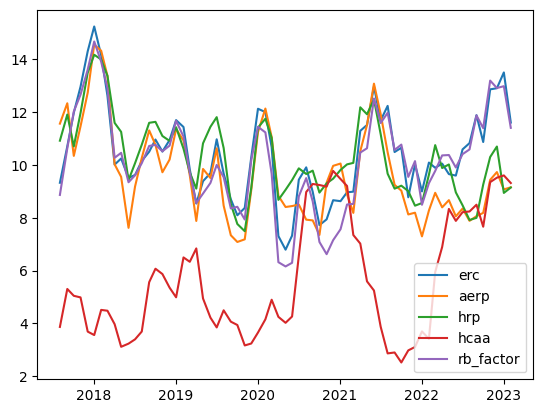

In [393]:
import pandas as pd

PORTFOLIOS = list(cv_results1[0][0]["port"].keys())
pc_bets1_new = {p: [] for p in PORTFOLIOS}
mt_bets1 = {p: [] for p in PORTFOLIOS}

rc_mt = {p: [] for p in PORTFOLIOS}

for t in range(len(cv_results1[0])):
    print(len(cv_results1[0])-t)
    W_tilde = np.dot(
        np.diag(cv_results1[0][t]["scaler"]["attributes"]["scale_"]), 
        cv_results1[0][t]["loading"]
     )
    ret = cv_results1[0][t]["returns"].values
    factors = cv_results1[0][t]["test_features"].values
    V_tilde = scipy.linalg.null_space(W_tilde.T).T
    res_factors = np.dot(np.linalg.pinv(V_tilde).T, ret.T).T
    all_factors = np.concatenate([factors, res_factors], axis=1)
    Sigma = np.cov(all_factors.T)
    
    t_pc = torsion(Sigma, 'pca')
    t_mt = torsion(Sigma, 'minimum-torsion',  method='exact')
    for p in PORTFOLIOS:
        w = cv_results1[0][t]["port"][p].values
        w = np.concatenate([np.dot(W_tilde.T, w), np.dot(V_tilde, w)])
        pc_bets1_new[p].append(np.real(np.array(EffectiveBets(w, Sigma, t_pc)[1])[0,0]))
        rc_i, nb = EffectiveBets(w, Sigma, t_mt)
        nb = np.real(np.array(nb)[0,0])
        mt_bets1[p].append(nb)
        rc_mt[p].append(np.real(np.asarray(rc_i)[:,0]))
pc_bets1_new = pd.DataFrame(pc_bets1_new, index=cv_dates1)
mt_bets1 = pd.DataFrame(mt_bets1, index=cv_dates1)
mt_bets1.drop("rb_factor_full_erc", axis=1, inplace=True)
plt.plot(mt_bets1.rolling(3).mean())
plt.legend(mt_bets1.columns)



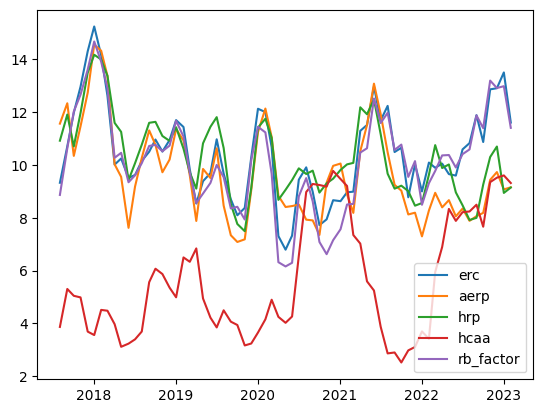

In [423]:
plt.plot(mt_bets1.rolling(3).mean())
plt.legend(mt_bets1.columns)


In [433]:
import pandas as pd

PORTFOLIOS = list(cv_results2[0][0]["port"].keys())
pc_bets2_new = {p: [] for p in PORTFOLIOS}
mt_bets2 = {p: [] for p in PORTFOLIOS}

rc_mt2 = {p: [] for p in PORTFOLIOS}

for t in range(len(cv_results2[0])):
    print(len(cv_results2[0])-t)
    W_tilde = np.dot(
        np.diag(cv_results2[0][t]["scaler"]["attributes"]["scale_"]), 
        cv_results2[0][t]["loading"]
     )
    ret = cv_results2[0][t]["returns"].values
    factors = cv_results2[0][t]["test_features"].values
    V_tilde = scipy.linalg.null_space(W_tilde.T).T
    res_factors = np.dot(np.linalg.pinv(V_tilde).T, ret.T).T
    all_factors = np.concatenate([factors, res_factors], axis=1)
    Sigma = np.cov(all_factors.T)
    
    t_pc = torsion(Sigma, 'pca')
    t_mt = torsion(Sigma, 'minimum-torsion',  method='exact')
    for p in PORTFOLIOS:
        w = cv_results2[0][t]["port"][p].values
        w = np.concatenate([np.dot(W_tilde.T, w), np.dot(V_tilde, w)])
        rc_i, nb = EffectiveBets(w, Sigma, t_mt)
        nb = np.real(np.array(nb)[0,0])
        mt_bets2[p].append(nb)
        rc_mt2[p].append(np.real(np.asarray(rc_i)[:,0]))
mt_bets2 = pd.DataFrame(mt_bets2, index=cv_dates2)
mt_bets2.drop("rb_factor_full_erc", axis=1, inplace=True)

382
[ 0  1  2  3  4  7  6  5  8  9 10 11 12 13 16 15 14]
[[0.0773582 ]
 [0.08784173]
 [0.44298451]
 [0.08289816]
 [0.02521482]
 [0.00304351]
 [0.01035518]
 [0.07702626]
 [0.0488175 ]
 [0.00898795]
 [0.00382259]
 [0.00183312]
 [0.01581339]
 [0.00184485]
 [0.00071577]
 [0.01317898]
 [0.09826347]]
[[7.32735940e-02]
 [1.89071552e-02]
 [6.25947756e-01]
 [2.43258520e-02]
 [7.80529533e-02]
 [7.53297655e-03]
 [6.16170754e-03]
 [4.08934446e-02]
 [1.23457347e-02]
 [1.81072948e-02]
 [1.18883820e-02]
 [4.65016302e-04]
 [4.02359106e-03]
 [2.03350412e-03]
 [2.07281348e-03]
 [6.85989037e-03]
 [6.71083336e-02]]
[[0.06615453]
 [0.00328475]
 [0.69414492]
 [0.00761429]
 [0.05008762]
 [0.00789239]
 [0.01314436]
 [0.01537162]
 [0.00172352]
 [0.01218153]
 [0.01429958]
 [0.00292533]
 [0.00088429]
 [0.02009094]
 [0.0133811 ]
 [0.01206853]
 [0.06475071]]
[[5.00077074e-02]
 [8.26948626e-04]
 [4.41356130e-05]
 [1.88991494e-02]
 [2.18585616e-02]
 [7.35786404e-01]
 [5.19304560e-02]
 [3.40090574e-03]
 [1.19315844e-

[[7.14108515e-02]
 [1.63615878e-01]
 [1.64207656e-01]
 [1.45879205e-01]
 [3.53793418e-02]
 [2.06938750e-01]
 [9.37974899e-02]
 [3.22912387e-03]
 [5.05734537e-02]
 [1.14908570e-02]
 [1.74450870e-02]
 [1.81346402e-02]
 [2.29265940e-03]
 [1.22908358e-02]
 [1.81448503e-03]
 [1.48286084e-07]
 [1.49953765e-03]]
[[8.37557242e-02]
 [1.52244074e-01]
 [1.45439266e-01]
 [1.40915871e-01]
 [4.04664079e-02]
 [2.05553535e-01]
 [1.14759391e-01]
 [3.15132964e-03]
 [4.87658362e-02]
 [1.18403361e-02]
 [1.67856888e-02]
 [1.78147906e-02]
 [1.98785522e-03]
 [1.24661680e-02]
 [2.24279914e-03]
 [3.55044333e-05]
 [1.77542259e-03]]
333
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 15]
[[1.52849555e-01]
 [1.57723577e-01]
 [2.30662085e-01]
 [1.27682754e-01]
 [6.16264047e-02]
 [9.97815466e-02]
 [2.00460806e-04]
 [1.71628568e-05]
 [3.24487872e-02]
 [1.10145622e-02]
 [6.39896439e-03]
 [1.62061226e-02]
 [1.72507629e-02]
 [2.35662416e-02]
 [3.97964183e-03]
 [3.05618747e-02]
 [2.80294965e-02]]
[[0.17824519]
 [0.1655

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 15]
[[0.01232353]
 [0.3984287 ]
 [0.19369729]
 [0.01139413]
 [0.00326623]
 [0.01818735]
 [0.09720799]
 [0.00293894]
 [0.08462266]
 [0.04177178]
 [0.00833351]
 [0.00194319]
 [0.0260126 ]
 [0.01332995]
 [0.01883183]
 [0.0521967 ]
 [0.01551364]]
[[2.19678206e-01]
 [1.36525415e-04]
 [2.93760329e-03]
 [2.95701828e-01]
 [1.74323430e-03]
 [9.26993044e-05]
 [1.20028838e-01]
 [3.09494614e-02]
 [3.45230985e-02]
 [1.90358519e-02]
 [9.69255405e-03]
 [2.65777387e-04]
 [1.71330972e-02]
 [1.65681273e-02]
 [4.68340687e-02]
 [1.13479008e-01]
 [7.12000212e-02]]
[[2.08379813e-01]
 [7.23907729e-05]
 [5.29947458e-03]
 [1.98140904e-01]
 [1.28794325e-03]
 [5.81039194e-03]
 [1.15616366e-01]
 [4.54759464e-02]
 [1.94247821e-02]
 [6.93183558e-02]
 [1.68630989e-02]
 [9.26405842e-05]
 [2.17732437e-02]
 [3.73849052e-02]
 [5.98316346e-02]
 [9.70252193e-02]
 [9.82028904e-02]]
[[5.70834711e-02]
 [6.39409591e-02]
 [7.10527749e-01]
 [4.59355219e-02]
 [5.91940954e-03]
 [2.

[[1.12514815e-01]
 [4.58814010e-01]
 [3.84220859e-03]
 [9.37813739e-03]
 [2.25196545e-03]
 [2.02691472e-02]
 [6.44544268e-04]
 [9.01386529e-02]
 [2.70179290e-03]
 [2.09013111e-02]
 [6.28342273e-03]
 [7.02615252e-08]
 [1.59246762e-02]
 [1.65952197e-01]
 [3.45607830e-02]
 [3.84616680e-02]
 [1.73605979e-02]]
[[6.88555369e-01]
 [3.80274867e-02]
 [1.44457044e-02]
 [2.99994151e-02]
 [2.38627394e-02]
 [1.95666308e-02]
 [9.10940184e-03]
 [1.18770594e-02]
 [2.60294036e-02]
 [4.16170049e-03]
 [4.09284521e-03]
 [1.99905584e-06]
 [6.98695165e-03]
 [8.76900357e-02]
 [2.08933980e-02]
 [1.44752070e-02]
 [2.24652709e-04]]
[[5.99415225e-01]
 [4.96250926e-02]
 [1.27906872e-02]
 [4.55504446e-02]
 [2.71871442e-02]
 [1.54512294e-02]
 [2.45806034e-04]
 [1.68559622e-03]
 [1.96706801e-02]
 [3.54769023e-03]
 [2.12655356e-03]
 [4.51741319e-04]
 [2.16282315e-02]
 [1.47628844e-01]
 [3.56632281e-02]
 [1.68636517e-02]
 [4.68154314e-04]]
[[1.53931108e-01]
 [5.73850233e-01]
 [2.30285921e-03]
 [1.61448990e-02]
 [4.087

[[2.22383118e-01]
 [8.96259929e-02]
 [7.34658330e-02]
 [2.80814376e-01]
 [2.15534550e-01]
 [3.18976830e-02]
 [3.96785837e-03]
 [2.22788272e-02]
 [1.03456395e-02]
 [1.74996102e-02]
 [1.38452566e-03]
 [1.43719287e-04]
 [9.25811553e-03]
 [1.37200987e-03]
 [7.56707222e-04]
 [1.10656205e-02]
 [8.20581324e-03]]
185
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 14]
[[2.32060868e-01]
 [2.25761060e-01]
 [1.34303150e-01]
 [1.70991414e-01]
 [1.12068246e-01]
 [1.96873638e-02]
 [5.11479671e-04]
 [6.60874523e-02]
 [3.89237083e-03]
 [1.94551304e-02]
 [1.12122228e-03]
 [3.19193033e-04]
 [1.98351255e-04]
 [8.99982252e-04]
 [6.05881092e-03]
 [4.82370003e-03]
 [1.76020565e-03]]
[[4.59840646e-02]
 [3.64732899e-01]
 [4.20383544e-01]
 [4.89771257e-02]
 [4.24310362e-02]
 [4.62275446e-04]
 [6.03017838e-04]
 [6.71065921e-03]
 [5.66636129e-04]
 [4.84022432e-02]
 [4.42570205e-04]
 [1.37657970e-04]
 [2.36735318e-03]
 [9.01217365e-03]
 [3.01918648e-03]
 [1.21262547e-03]
 [4.55493244e-03]]
[[1.52924527e-02]
 [3.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[2.40506516e-01]
 [2.86072909e-01]
 [6.10278445e-04]
 [1.40275722e-04]
 [1.06590265e-02]
 [3.11730922e-02]
 [2.30950473e-02]
 [1.22026851e-02]
 [4.31159271e-02]
 [2.38353520e-03]
 [2.50903248e-03]
 [7.41142373e-03]
 [3.06889092e-02]
 [2.19844581e-01]
 [4.06684130e-02]
 [9.66314379e-03]
 [3.92552040e-02]]
[[0.508466  ]
 [0.00337483]
 [0.01012159]
 [0.00363312]
 [0.00273024]
 [0.00749173]
 [0.00325012]
 [0.02875815]
 [0.02710365]
 [0.00618583]
 [0.00106608]
 [0.00339798]
 [0.02896335]
 [0.25310326]
 [0.05508035]
 [0.02130794]
 [0.03596578]]
[[3.74333322e-01]
 [2.81203887e-03]
 [3.55881164e-03]
 [3.16138848e-03]
 [3.70118152e-03]
 [2.70446375e-02]
 [5.25491310e-05]
 [2.77484683e-02]
 [2.29281024e-02]
 [5.87148211e-04]
 [5.11680188e-05]
 [3.46724540e-03]
 [2.96161165e-02]
 [4.03287226e-01]
 [6.56052237e-02]
 [1.84993692e-02]
 [1.35460029e-02]]
[[1.03357484e-01]
 [2.16279610e-01]
 [9.40933874e-03]
 [2.14052217e-02]
 [5.33225395e-02]
 [3.

[[1.17687322e-01]
 [5.60732633e-01]
 [1.29914412e-01]
 [9.36633964e-05]
 [2.10947110e-02]
 [3.67506330e-03]
 [5.12603747e-02]
 [1.89279168e-02]
 [1.24032018e-03]
 [1.43260696e-02]
 [7.97715335e-04]
 [9.02900027e-03]
 [4.61832554e-03]
 [2.77411887e-02]
 [6.06760108e-03]
 [1.36174292e-02]
 [1.91762542e-02]]
[[5.05490060e-01]
 [7.74955346e-05]
 [3.29999434e-01]
 [1.06399360e-03]
 [1.74507482e-03]
 [1.86108622e-02]
 [1.04138541e-02]
 [4.97059310e-03]
 [5.14139093e-04]
 [7.61281661e-02]
 [8.43334588e-06]
 [1.00022587e-03]
 [6.91668904e-03]
 [2.27955585e-02]
 [2.08641896e-03]
 [6.05750302e-03]
 [1.21214984e-02]]
[[0.35096526]
 [0.02111924]
 [0.07410362]
 [0.00296916]
 [0.00326368]
 [0.02433874]
 [0.00408901]
 [0.00309572]
 [0.0060299 ]
 [0.437201  ]
 [0.01740708]
 [0.00201588]
 [0.00080685]
 [0.00744353]
 [0.00699529]
 [0.0007253 ]
 [0.03743076]]
[[3.70937736e-01]
 [1.47175526e-01]
 [8.50950637e-02]
 [4.51349584e-04]
 [8.56679018e-03]
 [7.22493792e-04]
 [4.53876983e-03]
 [5.16604698e-02]
 [1

[[2.70168130e-01]
 [2.71755144e-01]
 [7.79336717e-02]
 [1.07235413e-02]
 [1.63671149e-06]
 [3.75105124e-02]
 [3.27478767e-02]
 [4.49753552e-03]
 [1.26460549e-03]
 [3.05335817e-05]
 [9.30205746e-03]
 [1.15775869e-02]
 [1.00874809e-02]
 [1.32652370e-01]
 [6.62895424e-02]
 [5.15045582e-02]
 [1.19532169e-02]]
41
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[1.59416693e-01]
 [4.54026600e-01]
 [2.64594545e-01]
 [3.53257554e-05]
 [1.59784800e-02]
 [6.37602802e-04]
 [4.54470900e-03]
 [6.30599870e-02]
 [7.37017743e-03]
 [8.31278396e-04]
 [9.47166955e-04]
 [1.96140815e-04]
 [1.58048699e-03]
 [5.95458424e-03]
 [1.10809840e-02]
 [8.42524313e-03]
 [1.31999577e-03]]
[[2.96091248e-01]
 [1.37191357e-01]
 [4.92496281e-01]
 [1.60456667e-03]
 [1.78353961e-03]
 [2.27174854e-04]
 [7.45807077e-03]
 [1.39155446e-04]
 [1.76252579e-02]
 [5.82872506e-03]
 [9.27970707e-03]
 [3.36554954e-03]
 [4.21167881e-03]
 [3.48116069e-03]
 [1.19109018e-02]
 [5.93119754e-03]
 [1.37442870e-03]]
[[2.77808724e-01]
 [8.7

[[ 4.36995757e-01-3.17520614e-07j]
 [ 4.48992029e-02-1.24169239e-07j]
 [ 6.49081882e-02+2.87130600e-07j]
 [ 7.22193602e-03+3.13138763e-08j]
 [ 1.20007722e-01+2.94104607e-07j]
 [ 2.35252072e-02+1.34165969e-07j]
 [ 1.77562138e-03+1.14772380e-08j]
 [ 9.03383553e-09+2.83904574e-09j]
 [ 4.16553699e-02-1.48958029e-07j]
 [ 1.60632456e-08-4.00309517e-08j]
 [-4.89503059e-10+1.25818346e-10j]
 [ 5.89953741e-02-1.38368828e-07j]
 [ 6.67626047e-03-1.83302676e-08j]
 [ 1.72711266e-04-9.83655954e-09j]
 [ 2.81143933e-06+1.73513149e-08j]
 [ 1.83907604e-01+9.57255196e-09j]
 [ 9.25620441e-03+1.37686402e-08j]]
[[ 4.40304781e-01-3.18334153e-07j]
 [ 3.11407592e-02-1.13139518e-07j]
 [ 7.56685443e-02+3.24949304e-07j]
 [ 1.10628494e-02+3.96071954e-08j]
 [ 9.55010120e-02+2.75706467e-07j]
 [ 1.95799124e-02+1.26503395e-07j]
 [ 1.56754435e-03+1.19238423e-08j]
 [ 1.15584156e-08+3.37257895e-09j]
 [ 5.88858628e-02-1.87632635e-07j]
 [ 1.64056147e-08-4.10105936e-08j]
 [-9.75850593e-10-2.73569344e-10j]
 [ 4.57419853e-02-1

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8d901a0280>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8d901a08e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8d90193ee0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8d901a0e50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8d901ad4c0>,
 'means': [<matplotlib.lines.Line2D at 0x7f8d901ad190>,
  <matplotlib.lines.Line2D at 0x7f8d780faac0>]}

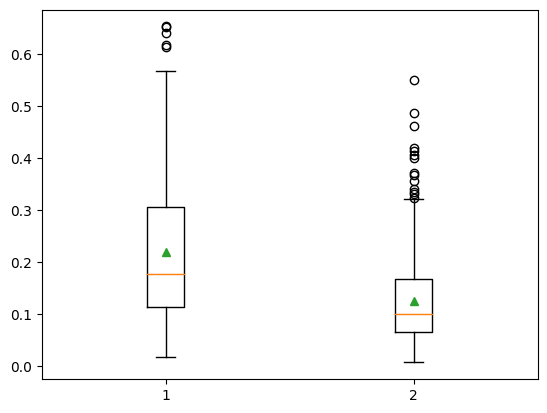

In [422]:
plt.boxplot([
    pd.DataFrame(rc_mt2["hrp"]).iloc[:,10:].sum(1),
    pd.DataFrame(rc_mt2["rb_factor"]).iloc[:,10:].sum(1),
], showmeans=True)

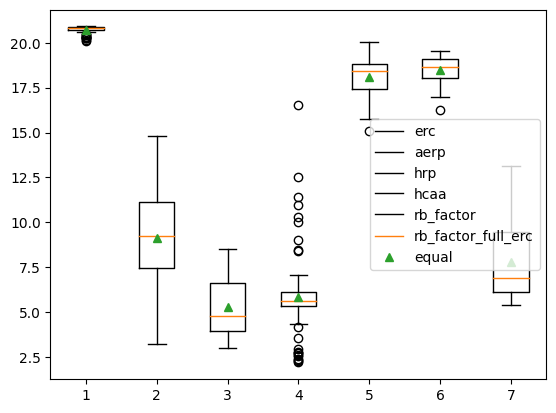

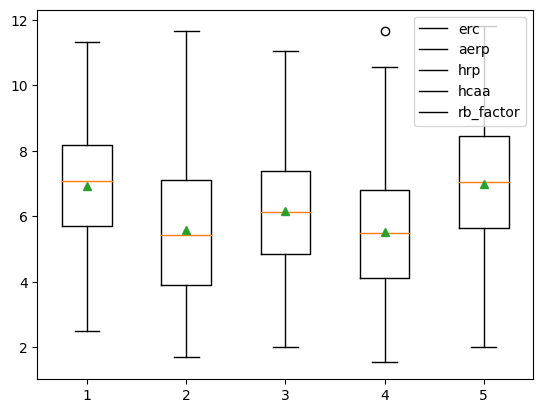

In [435]:
plt.boxplot(mt_bets1.T, showmeans=True)
plt.legend(mt_bets1.columns)
plt.show()
plt.boxplot(mt_bets2.T, showmeans=True)
plt.legend(mt_bets2.columns)
plt.show()

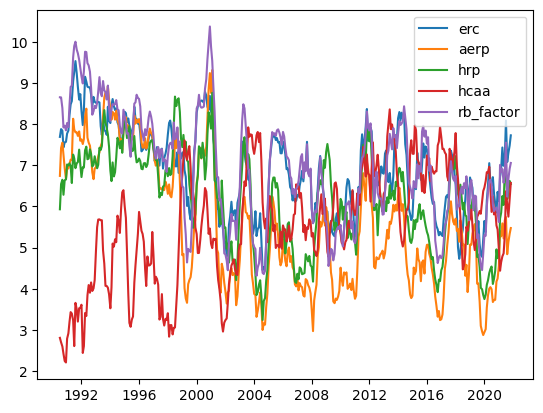

In [430]:
plt.plot(mt_bets2.rolling(6).mean())
plt.legend(mt_bets2.columns)

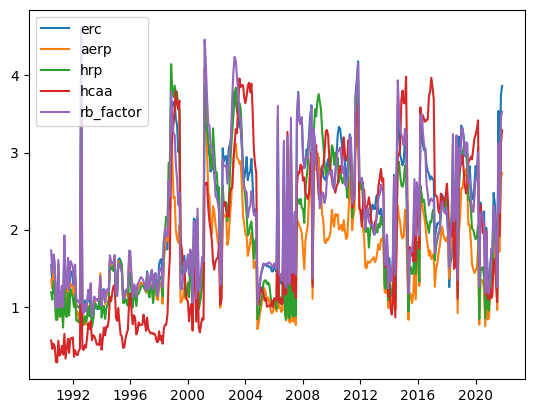

In [402]:
plt.plot(mt_bets2.rolling(6).mean()/np.array(loading_shape2).reshape(-1,1))
plt.legend(mt_bets2.columns)


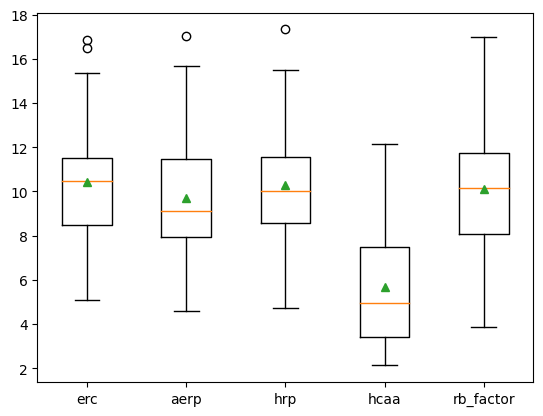

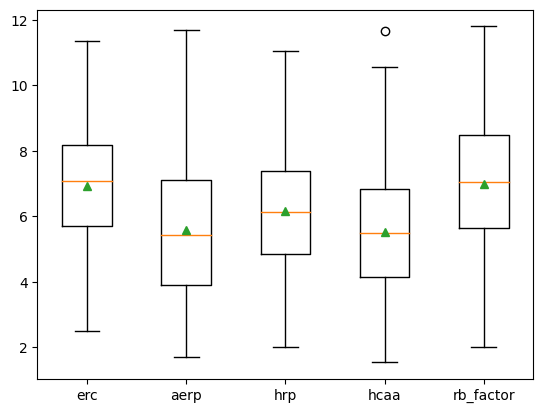

In [413]:
plt.boxplot(mt_bets1.T, showmeans=True)
plt.xticks(range(1, 6), mt_bets1.columns)
plt.show()

plt.boxplot(mt_bets2.T, showmeans=True)
plt.xticks(range(1, 6), mt_bets2.columns)
plt.show()

In [328]:
import pandas as pd

PORTFOLIOS = list(cv_results2[0][0]["port"].keys())
pc_bets2_new = {p: [] for p in PORTFOLIOS}
mt_bets2 = {p: [] for p in PORTFOLIOS}

rc_mt2 = {p: [] for p in PORTFOLIOS}

for t in range(len(cv_results2[0])):
    print(len(cv_results2[0])-t)
    Sigma = np.cov(cv_results2[0][t]["train_returns"].T)
    t_pc = torsion(Sigma, 'pca')
    t_mt = torsion(Sigma, 'minimum-torsion',  method='exact')
    for p in PORTFOLIOS:
        w = cv_results2[0][t]["port"][p].values
        pc_bets2_new[p].append(np.real(np.array(EffectiveBets(w, Sigma, t_pc)[1])[0,0]))
        
        rc_i, nb = EffectiveBets(w, Sigma, t_mt)
        nb = np.real(np.array(nb)[0,0])
        mt_bets2[p].append(nb)
        rc_mt2[p].append(np.real(np.asarray(rc_i)[:,0]))
pc_bets2_new = pd.DataFrame(pc_bets2_new, index=cv_dates2)
mt_bets2 = pd.DataFrame(mt_bets2, index=cv_dates2)


382
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 14]
[[ 0.11975323]
 [-0.00868776]
 [ 0.00241922]
 [ 0.05000733]
 [ 0.23950718]
 [ 0.07390242]
 [ 0.00265295]
 [ 0.02634934]
 [ 0.04959107]
 [ 0.17819175]
 [-0.01387312]
 [ 0.12226377]
 [-0.03364763]
 [ 0.15536707]
 [ 0.02601033]
 [-0.00407266]
 [ 0.01426551]]
[[0.04894691]
 [0.05949605]
 [0.05059665]
 [0.06696519]
 [0.05770861]
 [0.05756642]
 [0.05281275]
 [0.05709067]
 [0.0751011 ]
 [0.06989975]
 [0.05520231]
 [0.04764586]
 [0.05952558]
 [0.05042594]
 [0.06332539]
 [0.06949255]
 [0.05819827]]
[[ 6.00660190e-02]
 [ 4.58108879e-02]
 [ 3.51061502e-02]
 [-6.00280997e-02]
 [ 2.21020054e-01]
 [ 1.53233693e-01]
 [ 5.94433091e-03]
 [ 1.76881771e-02]
 [ 7.14769968e-03]
 [ 1.97589739e-01]
 [-5.21764235e-02]
 [ 1.08429381e-01]
 [ 2.42175870e-02]
 [ 2.24041948e-01]
 [ 2.92058600e-02]
 [-1.74495715e-02]
 [ 1.52568236e-04]]
[[0.03720945]
 [0.04791356]
 [0.01795788]
 [0.04248695]
 [0.01893372]
 [0.01541676]
 [0.01123781]
 [0.20434793]
 [0.00938129

/var/folders/42/lvxjy6497p5cc815gnmf33tm0000gn/T/ipykernel_13426/1670824573.py:8: RuntimeWarning: invalid value encountered in log
  enb = np.exp(- p.T * np.log(p + 1e-6))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 14]
[[-0.2253839 ]
 [ 0.09359604]
 [ 0.03215883]
 [ 0.80063015]
 [ 0.01429862]
 [-0.08089929]
 [-0.05768719]
 [ 0.08259352]
 [ 0.07620194]
 [ 0.03913499]
 [ 0.06602013]
 [ 0.09059865]
 [-0.01210103]
 [ 0.03079565]
 [ 0.02071161]
 [ 0.02781269]
 [ 0.00151858]]
[[0.05688009]
 [0.05827565]
 [0.06127441]
 [0.05504576]
 [0.05553104]
 [0.04815857]
 [0.06051563]
 [0.07096587]
 [0.06200417]
 [0.06441815]
 [0.04860867]
 [0.04883133]
 [0.06936091]
 [0.06386837]
 [0.05920198]
 [0.05903282]
 [0.05802657]]
[[-0.18489037]
 [ 0.10695711]
 [ 0.01951497]
 [ 0.67512144]
 [-0.01968365]
 [-0.07796042]
 [-0.05397015]
 [ 0.1170997 ]
 [ 0.08746845]
 [ 0.04844408]
 [ 0.06439695]
 [ 0.10130307]
 [ 0.00900729]
 [ 0.03084331]
 [ 0.0278183 ]
 [ 0.06071084]
 [-0.01218093]]
[[0.03965445]
 [0.03217351]
 [0.03892087]
 [0.03287333]
 [0.02907468]
 [0.01883337]
 [0.05261161]
 [0.11746461]
 [0.04524865]
 [0.08505881]
 [0.06441819]
 [0.06310479]
 [0.08576915]
 [0.08384364]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[ 0.1360318 ]
 [ 0.12468196]
 [-0.00389107]
 [ 0.01789182]
 [-0.01618804]
 [-0.02080203]
 [ 0.00304539]
 [ 0.22138633]
 [ 0.1199874 ]
 [ 0.01397227]
 [ 0.06692239]
 [ 0.16031224]
 [ 0.13758775]
 [ 0.01114413]
 [ 0.06774557]
 [-0.04313381]
 [ 0.0033059 ]]
[[0.05655663]
 [0.06553587]
 [0.07004624]
 [0.05892   ]
 [0.07368567]
 [0.05137983]
 [0.06489841]
 [0.05766876]
 [0.0615394 ]
 [0.06451125]
 [0.04475509]
 [0.04187536]
 [0.06212872]
 [0.05234164]
 [0.04936365]
 [0.06259304]
 [0.06220043]]
[[ 0.20789562]
 [ 0.13861384]
 [-0.00177886]
 [-0.0859678 ]
 [-0.01365762]
 [-0.03450187]
 [ 0.00148365]
 [ 0.24098546]
 [ 0.04086139]
 [ 0.02316784]
 [ 0.0665473 ]
 [ 0.18691538]
 [ 0.16026048]
 [ 0.01091971]
 [ 0.09062622]
 [-0.0370118 ]
 [ 0.00464106]]
[[0.04642828]
 [0.05364216]
 [0.06072933]
 [0.04715025]
 [0.06257495]
 [0.03123526]
 [0.04232828]
 [0.12201989]
 [0.04284711]
 [0.06590612]
 [0.04670672]
 [0.04335294]
 [0.06487851]
 [0.06312624]


[ 0  1  2  3  4  5  6  7  8  9 11 10 12 13 14 15 16]
[[-0.01494163]
 [ 0.01580231]
 [ 0.00820085]
 [ 0.20216059]
 [ 0.0053505 ]
 [ 0.26321477]
 [ 0.33504679]
 [-0.04719598]
 [ 0.01125507]
 [ 0.09960696]
 [ 0.00291755]
 [-0.03536775]
 [ 0.06607255]
 [ 0.29540316]
 [-0.23636872]
 [ 0.03303489]
 [-0.0041919 ]]
[[0.052924  ]
 [0.05510712]
 [0.06013205]
 [0.0632601 ]
 [0.06139436]
 [0.05833568]
 [0.05320022]
 [0.06033596]
 [0.05964272]
 [0.05662895]
 [0.0579543 ]
 [0.05113436]
 [0.06569685]
 [0.05387102]
 [0.06799   ]
 [0.06261584]
 [0.05977646]]
[[ 0.00643258]
 [ 0.07577256]
 [ 0.09673597]
 [-0.00855258]
 [ 0.10077628]
 [ 0.10732928]
 [-0.0756888 ]
 [ 0.14936921]
 [ 0.00396944]
 [ 0.34678034]
 [-0.00930418]
 [ 0.20368525]
 [ 0.00247653]
 [ 0.37499149]
 [-0.38505846]
 [ 0.04242874]
 [-0.03214367]]
[[1.32070292e-04]
 [4.90591396e-04]
 [2.35547413e-06]
 [3.72256462e-05]
 [2.53428163e-06]
 [4.41226680e-04]
 [6.02739650e-03]
 [3.26190614e-04]
 [1.19614296e-03]
 [1.34893431e-01]
 [1.26403770e-01

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[ 0.24063925]
 [-0.00680155]
 [ 0.04531506]
 [-0.0883973 ]
 [ 0.14228319]
 [ 0.03670527]
 [-0.00104612]
 [ 0.0182696 ]
 [ 0.0355221 ]
 [ 0.25606875]
 [-0.0405457 ]
 [ 0.10818081]
 [-0.23797018]
 [ 0.08543063]
 [-0.09462509]
 [ 0.43227883]
 [ 0.06869245]]
[[0.05876326]
 [0.05869851]
 [0.04875153]
 [0.05944916]
 [0.05165371]
 [0.06444302]
 [0.05712659]
 [0.05914618]
 [0.05842663]
 [0.06632852]
 [0.04484089]
 [0.04639115]
 [0.0893755 ]
 [0.05179251]
 [0.0477003 ]
 [0.05200922]
 [0.08510331]]
[[ 5.98393365e-02]
 [-4.57849921e-04]
 [-3.88129143e-03]
 [ 1.23567067e-01]
 [ 4.34097306e-02]
 [ 8.41846939e-03]
 [ 3.08646629e-05]
 [ 2.65690451e-02]
 [ 3.84721872e-04]
 [ 6.99732607e-01]
 [ 1.43483427e-01]
 [-4.77635349e-01]
 [ 1.84836370e-02]
 [ 2.91417868e-01]
 [-1.19088401e-01]
 [ 1.97553690e-01]
 [-1.18275726e-02]]
[[7.28067014e-05]
 [6.71888670e-04]
 [2.10397172e-03]
 [1.07903367e-04]
 [3.69802832e-04]
 [1.45662587e-05]
 [4.56608253e-04]
 [

[[ 0.03720696]
 [-0.05912073]
 [-0.11678243]
 [-0.02165584]
 [-0.02940012]
 [ 0.55018826]
 [-0.04686742]
 [ 0.01746841]
 [ 0.01550614]
 [-0.50060925]
 [ 0.12086984]
 [ 0.2516162 ]
 [ 0.16702892]
 [ 0.29062286]
 [-0.13926617]
 [ 0.27491266]
 [ 0.18828171]]
[[4.38758479e-03]
 [3.94907241e-04]
 [1.30754105e-04]
 [4.17570405e-03]
 [2.39030495e-03]
 [2.44090248e-03]
 [1.09994673e-02]
 [7.13425454e-03]
 [4.94631436e-02]
 [1.73481360e-01]
 [6.24378755e-02]
 [4.89867115e-02]
 [8.93141400e-02]
 [2.19254325e-01]
 [1.12809811e-01]
 [7.48447150e-02]
 [1.37354039e-01]]
[[ 2.49789284e-01]
 [-2.93541092e-02]
 [ 4.43559972e-03]
 [ 2.81294395e-02]
 [ 6.63237452e-02]
 [-9.94800516e-05]
 [ 5.11158270e-02]
 [ 1.02184944e-01]
 [ 1.74616201e-01]
 [-1.26527577e-04]
 [ 1.60255613e-03]
 [-8.61112927e-04]
 [ 4.52968763e-02]
 [ 7.07407849e-03]
 [ 1.04453757e-02]
 [ 3.26598213e-02]
 [ 2.56767481e-01]]
[[0.17551621]
 [0.03203948]
 [0.02498409]
 [0.22036912]
 [0.03453208]
 [0.0400101 ]
 [0.19425326]
 [0.11199007]
 

[[ 0.30318716]
 [-0.00127367]
 [ 0.10203119]
 [-0.18729283]
 [ 0.05511051]
 [ 0.01959595]
 [ 0.00099418]
 [ 0.00697606]
 [ 0.00156216]
 [-0.05698615]
 [ 0.72867854]
 [ 0.09451511]
 [-0.09716215]
 [-0.06094364]
 [-0.39704957]
 [ 0.52416634]
 [-0.03610918]]
[[4.16238937e-07]
 [1.05933173e-03]
 [2.10572041e-04]
 [8.09473998e-06]
 [2.13174771e-04]
 [5.06158600e-05]
 [2.37042574e-05]
 [8.15811205e-04]
 [5.14583715e-03]
 [1.35063334e-01]
 [8.94736552e-02]
 [7.84706162e-02]
 [1.89858681e-01]
 [1.23921995e-01]
 [1.11936010e-01]
 [1.00046302e-01]
 [1.63701848e-01]]
[[ 0.54613353]
 [ 0.02482463]
 [ 0.09435581]
 [-0.47561771]
 [ 0.0778804 ]
 [-0.00443163]
 [ 0.00767481]
 [ 0.0160876 ]
 [ 0.00583689]
 [-0.14420077]
 [ 0.70396405]
 [ 0.39301422]
 [-0.28993139]
 [-0.35361642]
 [-1.32174336]
 [ 2.19497656]
 [-0.47520721]]
[[0.00138272]
 [0.01009911]
 [0.00599171]
 [0.0003132 ]
 [0.00909704]
 [0.00744164]
 [0.00592593]
 [0.00033335]
 [0.00294557]
 [0.12420269]
 [0.05965994]
 [0.04014666]
 [0.07549671]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[[ 1.27528707e-01]
 [-3.90881140e-05]
 [ 1.37614771e-01]
 [ 2.27846096e-01]
 [ 1.38839798e-01]
 [-7.16657419e-02]
 [ 2.63636407e-02]
 [-5.75912749e-03]
 [ 3.86952571e-02]
 [-1.23135170e-01]
 [ 1.14720211e-01]
 [-1.36842974e-01]
 [ 5.25685087e-01]
 [ 1.60826684e-02]
 [ 3.21824133e-02]
 [-4.77126442e-02]
 [-4.03904458e-04]]
[[0.04787725]
 [0.0508913 ]
 [0.05310409]
 [0.05608279]
 [0.05299073]
 [0.0661977 ]
 [0.06840327]
 [0.07045564]
 [0.06851698]
 [0.07102309]
 [0.05054448]
 [0.04369269]
 [0.062043  ]
 [0.0699661 ]
 [0.04773432]
 [0.05833526]
 [0.06214132]]
[[ 4.23296938e-01]
 [-4.02004519e-02]
 [-1.49996039e-01]
 [-4.14500932e-01]
 [ 1.22267004e-01]
 [ 6.96305566e-02]
 [-1.27074014e-03]
 [ 6.16770770e-02]
 [-1.66532000e-02]
 [-3.38999137e-01]
 [-7.53658986e-01]
 [ 2.37075044e+00]
 [-2.84962348e-01]
 [ 1.85954049e-02]
 [ 1.43086286e-02]
 [-5.72632426e-02]
 [-2.30209682e-02]]
[[0.0114152 ]
 [0.00391233]
 [0.00352879]
 [0.0108262 ]
 [0.

[[ 0.02633966]
 [-0.25611121]
 [-0.01561163]
 [ 0.02222497]
 [-0.34326175]
 [ 1.23259931]
 [ 0.00531246]
 [-0.33171667]
 [ 0.00520087]
 [ 0.01488959]
 [ 0.00219079]
 [-0.00242073]
 [ 0.00601028]
 [ 0.32221575]
 [ 0.79146458]
 [-0.68825452]
 [ 0.20892824]]
[[0.05352132]
 [0.06123341]
 [0.05835716]
 [0.05597994]
 [0.05144729]
 [0.05317119]
 [0.07332722]
 [0.05501404]
 [0.05898065]
 [0.08513895]
 [0.05900086]
 [0.04048065]
 [0.05307312]
 [0.0619067 ]
 [0.05949911]
 [0.05285704]
 [0.06701135]]
[[ 3.23732424e-01]
 [ 1.27110646e-01]
 [-3.16634833e-01]
 [ 1.23288272e-01]
 [-4.53437783e-01]
 [ 7.13458687e-01]
 [ 6.09009500e-03]
 [-4.07662131e-01]
 [-1.36019030e-03]
 [ 3.33860668e-02]
 [ 5.96082194e-03]
 [ 6.64428984e-04]
 [ 8.59895170e-05]
 [ 5.33864752e-01]
 [ 1.02167426e+00]
 [-6.98056008e-01]
 [-1.21654959e-02]]
[[3.00925763e-04]
 [6.88852733e-04]
 [3.96918719e-04]
 [2.29261631e-04]
 [1.77761843e-04]
 [5.07665102e-06]
 [5.64930554e-03]
 [6.41126778e-03]
 [3.21316788e-02]
 [1.69082295e-01]
 

[[-0.14830492]
 [ 0.07842395]
 [-0.17721853]
 [ 0.35412359]
 [ 0.05844424]
 [ 0.08559579]
 [ 0.20414236]
 [-0.00117242]
 [ 0.02751535]
 [-0.0914142 ]
 [ 0.60352773]
 [-0.21801946]
 [-0.03550681]
 [ 0.19417909]
 [-0.20517208]
 [ 0.13355504]
 [ 0.13730127]]
[[0.04043941]
 [0.09308232]
 [0.07425839]
 [0.04461811]
 [0.07209431]
 [0.08045103]
 [0.07420618]
 [0.00278756]
 [0.00070717]
 [0.0532542 ]
 [0.0356265 ]
 [0.03567171]
 [0.05860847]
 [0.11211499]
 [0.08135665]
 [0.07045228]
 [0.07027072]]
[[-0.14239202]
 [ 0.07313983]
 [-0.1658353 ]
 [ 0.33824209]
 [ 0.056733  ]
 [ 0.08619501]
 [ 0.19735415]
 [-0.00131202]
 [ 0.02370876]
 [-0.10961919]
 [ 0.68711578]
 [-0.25577796]
 [-0.04217006]
 [ 0.20777008]
 [-0.22184056]
 [ 0.13939365]
 [ 0.12929476]]
[[0.03837637]
 [0.08946579]
 [0.07127732]
 [0.04256124]
 [0.06890452]
 [0.07722001]
 [0.07099976]
 [0.00304751]
 [0.00067771]
 [0.05238226]
 [0.03529638]
 [0.03543362]
 [0.05859482]
 [0.12174406]
 [0.08741677]
 [0.07387533]
 [0.07272653]]
62
[ 0  1 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 15]
[[-0.07504954]
 [ 0.03819968]
 [-0.12334093]
 [ 0.08113042]
 [ 0.18073368]
 [-0.19250181]
 [ 0.17548003]
 [ 0.29042084]
 [ 0.0030733 ]
 [-0.31889657]
 [ 0.05084141]
 [ 0.67898926]
 [-0.08501034]
 [ 0.32965082]
 [ 0.00400346]
 [-0.13265552]
 [ 0.09493181]]
[[0.05011873]
 [0.06183011]
 [0.05971674]
 [0.05252868]
 [0.05365459]
 [0.06068558]
 [0.0693272 ]
 [0.05864082]
 [0.06946417]
 [0.06106558]
 [0.04815168]
 [0.03285042]
 [0.06891189]
 [0.06651242]
 [0.06238681]
 [0.0512019 ]
 [0.0729527 ]]
[[-2.78177266e-04]
 [-2.91477806e-02]
 [ 7.20623470e-02]
 [-3.48074831e-02]
 [-3.27624512e-02]
 [-8.99910659e-02]
 [-1.17223353e-01]
 [ 5.72952815e-01]
 [ 7.88646970e-04]
 [-4.64709743e-01]
 [ 4.96071229e-01]
 [ 2.99326152e-02]
 [ 1.20017268e-01]
 [ 6.26090133e-01]
 [ 3.09217748e-01]
 [-4.60108497e-01]
 [ 1.89574978e-03]]
[[2.32676823e-03]
 [8.02438542e-07]
 [7.94601710e-06]
 [2.38690837e-03]
 [3.80510925e-04]
 [3.83074742e-05]
 [6.09449998e-05]
 [

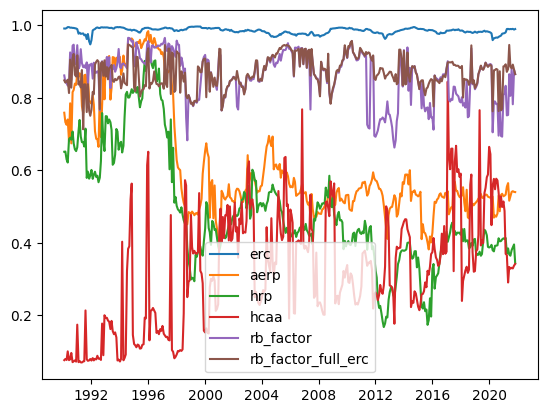

In [330]:
plt.plot(mt_bets2 / len(assets2))
plt.legend(PORTFOLIOS)
plt.show()

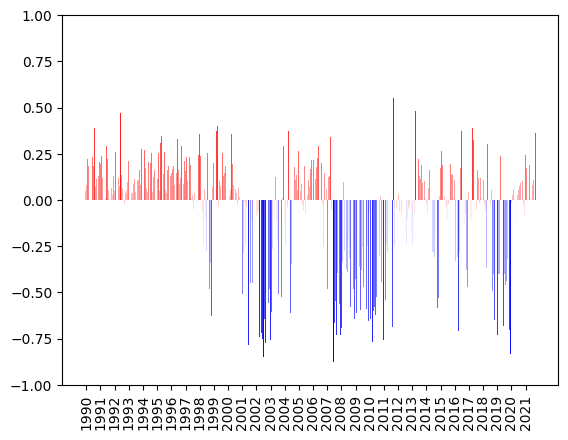

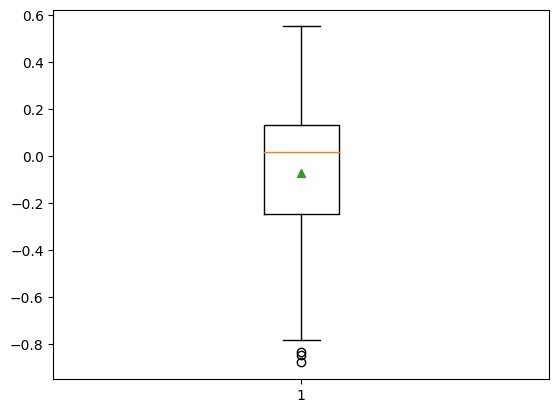

In [172]:
my_cmap = plt.get_cmap("bwr")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
avg_cv_corr = [
    np.mean(
        cv_results2[0][i]["test_features"].corr().values[
            np.triu_indices(cv_results2[0][i]["test_features"].shape[-1], k = 1)
        ]
    ) for i in range(n_cv2)
]
plt.bar(range(n_cv2), avg_cv_corr, color=my_cmap(rescale(avg_cv_corr)))
_ = plt.xticks(range(1, n_cv2, 12), np.array([d.strftime("%Y") for d in cv_dates2])[range(1, n_cv2, 12)], 
               rotation=90)
plt.ylim(-1, 1)
plt.show()
plt.boxplot(avg_cv_corr, showmeans=True)
plt.show()

In [ ]:

nmf_bets = get_number_of_nmf_bets(rc_port2).drop("rb_factor_full_erc", axis=1)
nmf_bets.index = cv_dates2

plt.figure(figsize=(10,5))
plt.plot(nmf_bets.rolling(3).mean())
plt.ylim(0, 12)
if save:
    plt.savefig(f"{savedir}/nmf_bets_ts_2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(nmf_bets.columns)

pc_bets = get_number_of_pc_bets(cv_results2, market_budget2).drop("rb_factor_full_erc", axis=1)
pc_bets.index = cv_dates2

plt.figure(figsize=(10,5))
plt.plot(pc_bets.rolling(3).mean())
plt.ylim(0, 12)
if save:
    plt.savefig(f"{savedir}/pc_bets_ts_2.png", transparent=True, bbox_inches="tight")
else:
    plt.legend(pc_bets.columns)
plt.show()

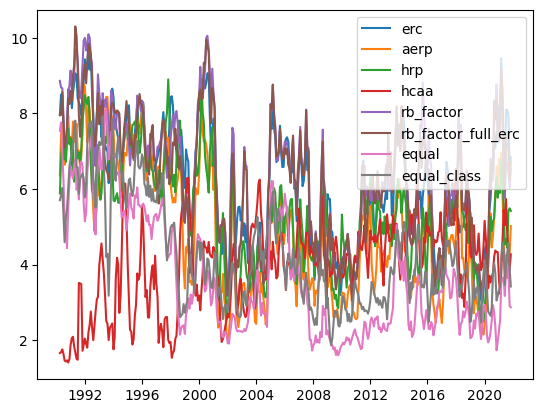

In [80]:
n_bets = get_number_of_nmf_bets(rc_port2)
n_bets.index = cv_dates2

_ = plt.plot(n_bets.rolling(3).mean())
plt.legend(n_bets.columns)

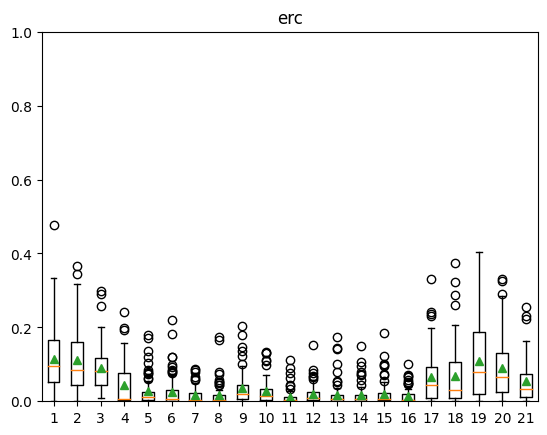

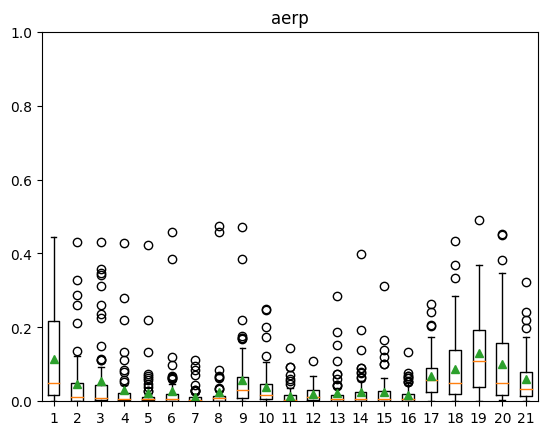

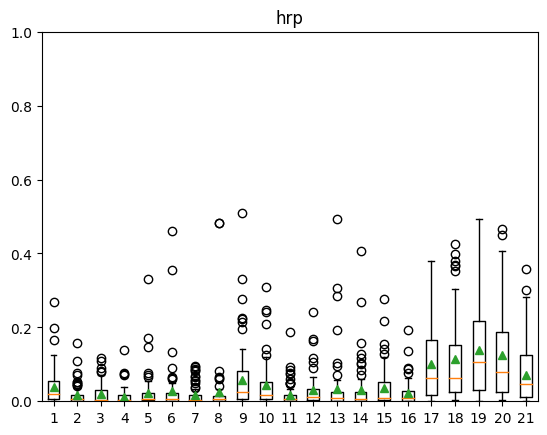

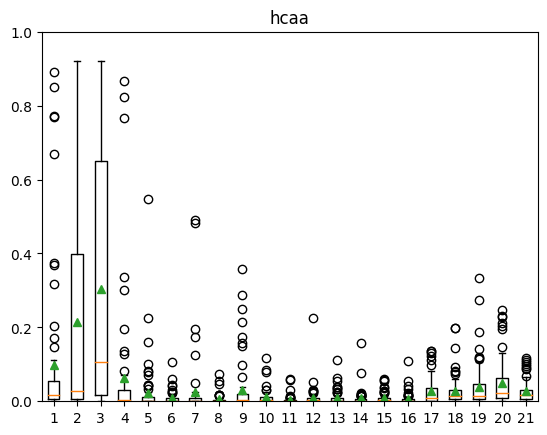

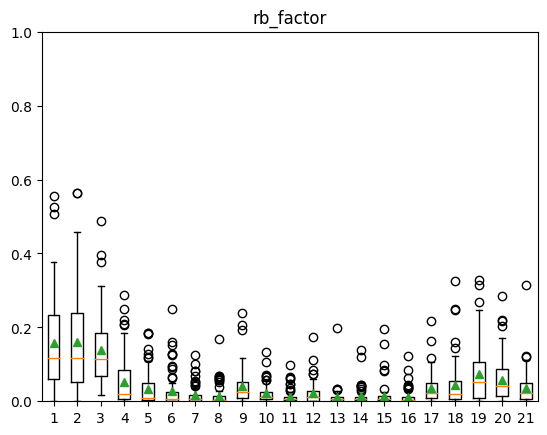

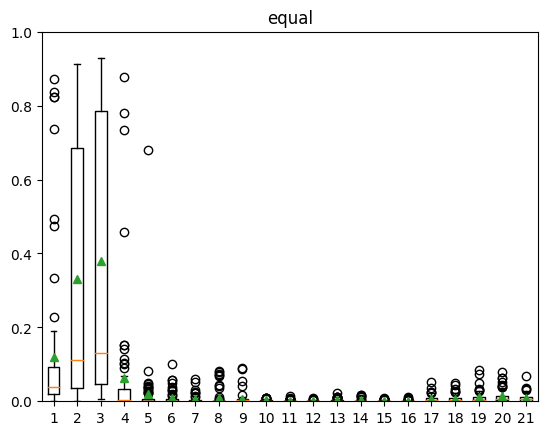

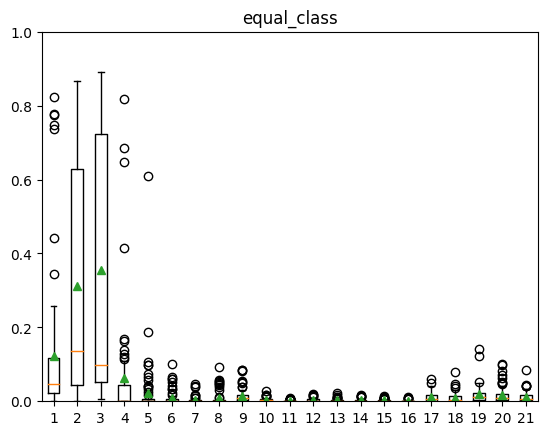

In [121]:

save=True # SAVE
for p in rc_port.keys():
    if p != "rb_factor_full_erc":
        rc = rc_port[p][0]
        norm_rc = rc.abs() / rc.abs().sum(1).values.reshape(-1, 1)
        plt.boxplot(norm_rc.T, showmeans=True, vert=True)
        plt.ylim(0,1)
        if save:
            plt.savefig(f"{savedir}/factor_rc_{p}_1.png", transparent=True, bbox_inches="tight")
        plt.title(p)
        plt.show()

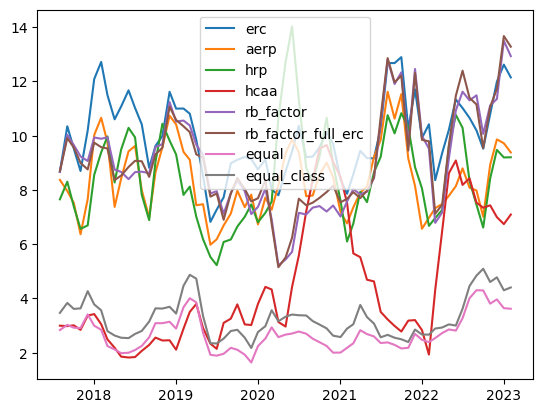

In [12]:
import itertools
D = pd.DataFrame(0, index=assets, columns=assets)

clustering_res = []
for i in range(n_cv):
    w = cv_results[0][i]["loading"].copy() ** 2
    w[w < 0.05] = 0
    clustering_res.append((w > 0).apply(lambda x: np.array(assets)[x].tolist(), 
                                        result_type="reduce", axis=0).to_dict())
    # clustering_res.append((w > 0).apply(lambda x: np.array(assets)[np.where(x)].tolist()).to_dict())
    
for i, c_res in enumerate(clustering_res):
    for cluster in c_res.values():
        if len(cluster) > 1:
            perms = np.array(list(itertools.permutations(cluster, 2)))
            D.loc[perms[:,0], perms[:, 1]] += 1
        else:
            D.loc[cluster, cluster] += 1
D = D / n_cv
D = D.values
D[np.diag_indices(D.shape[-1])] = 1
D = pd.DataFrame(D, index=assets, columns=assets)
sns.heatmap(D)

UK_B      US_B      JP_B      GE_B    CNY_FX    EUR_FX  \
UK_B      1.000000  0.971014  0.391304  1.000000  0.072464  0.246377   
US_B      0.971014  1.000000  0.391304  0.971014  0.115942  0.289855   
JP_B      0.391304  0.391304  1.000000  0.391304  0.000000  0.173913   
GE_B      1.000000  0.971014  0.391304  1.000000  0.072464  0.246377   
CNY_FX    0.072464  0.115942  0.000000  0.072464  1.000000  0.521739   
EUR_FX    0.246377  0.289855  0.173913  0.246377  0.521739  1.000000   
GBP_FX    0.173913  0.217391  0.173913  0.173913  0.550725  0.869565   
JPY_FX    0.753623  0.840580  0.318841  0.753623  0.333333  0.565217   
GOLDS_C   0.492754  0.565217  0.202899  0.492754  0.449275  0.550725   
EPRA_X    0.000000  0.000000  0.000000  0.000000  0.260870  0.275362   
MXWD_X    0.000000  0.000000  0.000000  0.000000  0.260870  0.275362   
NKY_X     0.000000  0.000000  0.000000  0.000000  0.144928  0.057971   
SHCOMP_X  0.000000  0.000000  0.043478  0.000000  0.362319  0.086957   
SPX_X     0.000000  0.000000  0.000000  0.000000  0.246377  0.260870   
SX5E_X    0.000000  0.000000  0.000000  0.000000  0.260870  0.275362   
UKX_X     0.000000  0.000000  0.000000  0.000000  0.260870  0.275362   
ETH       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LTC       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
DASH      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
XRP       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
BTC       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            GBP_FX    JPY_FX   GOLDS_C    EPRA_X  ...     NKY_X  SHCOMP_X  \
UK_B      0.173913  0.753623  0.492754  0.000000  ...  0.000000  0.000000   
US_B      0.217391  0.840580  0.565217  0.000000  ...  0.000000  0.000000   
JP_B      0.173913  0.318841  0.202899  0.000000  ...  0.000000  0.043478   
GE_B      0.173913  0.753623  0.492754  0.000000  ...  0.000000  0.000000   
CNY_FX    0.550725  0.333333  0.449275  0.260870  ...  0.144928  0.362319   
EUR_FX    0.869565  0.565217  0.550725  0.275362  ...  0.057971  0.086957   
GBP_FX    1.000000  0.492754  0.478261  0.478261  ...  0.202899  0.275362   
JPY_FX    0.492754  1.000000  0.869565  0.000000  ...  0.028986  0.028986   
GOLDS_C   0.478261  0.869565  1.000000  0.043478  ...  0.101449  0.101449   
EPRA_X    0.478261  0.000000  0.043478  1.000000  ...  0.318841  0.304348   
MXWD_X    0.478261  0.000000  0.043478  0.855072  ...  0.318841  0.304348   
NKY_X     0.202899  0.028986  0.101449  0.318841  ...  1.000000  0.405797   
SHCOMP_X  0.275362  0.028986  0.101449  0.304348  ...  0.405797  1.000000   
SPX_X     0.463768  0.000000  0.028986  0.840580  ...  0.304348  0.289855   
SX5E_X    0.478261  0.000000  0.043478  0.985507  ...  0.318841  0.304348   
UKX_X     0.478261  0.000000  0.043478  0.985507  ...  0.318841  0.304348   
ETH       0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
LTC       0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
DASH      0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
XRP       0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
BTC       0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   

             SPX_X    SX5E_X     UKX_X       ETH       LTC      DASH  \
UK_B      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
US_B      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
JP_B      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GE_B      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
CNY_FX    0.246377  0.260870  0.260870  0.000000  0.000000  0.000000   
EUR_FX    0.260870  0.275362  0.275362  0.000000  0.000000  0.000000   
GBP_FX    0.463768  0.478261  0.478261  0.000000  0.000000  0.000000   
JPY_FX    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
GOLDS_C   0.028986  0.043478  0.043478  0.000000  0.000000  0.000000   
EPRA_X    0.84

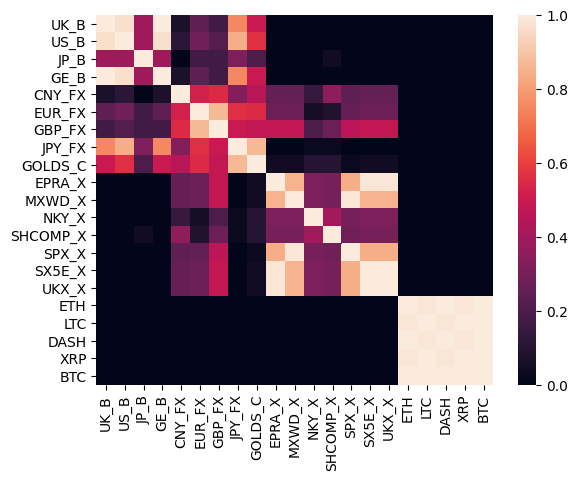

# Dataset 2

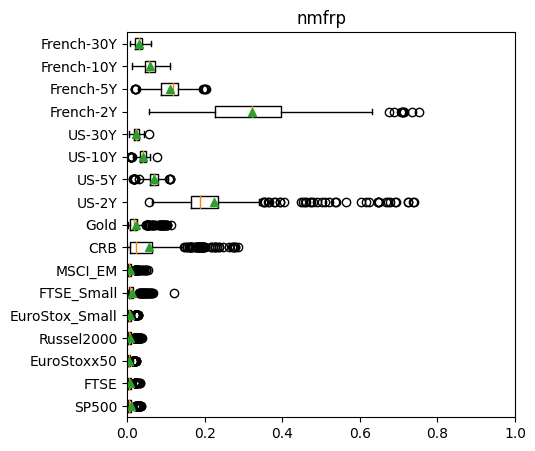

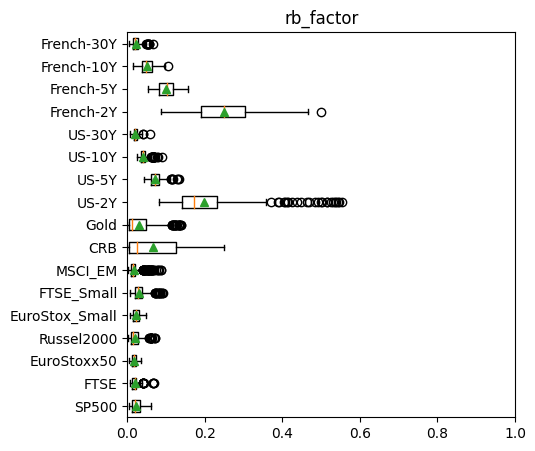

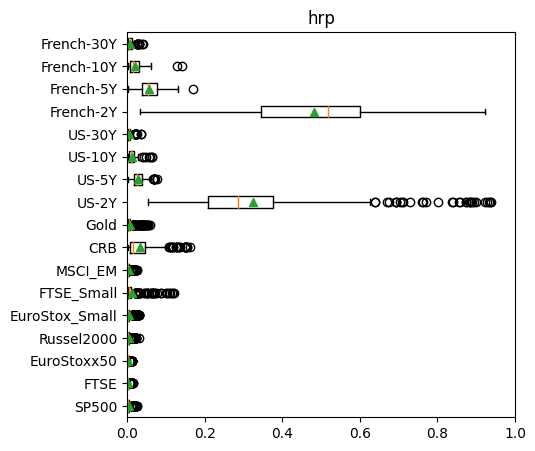

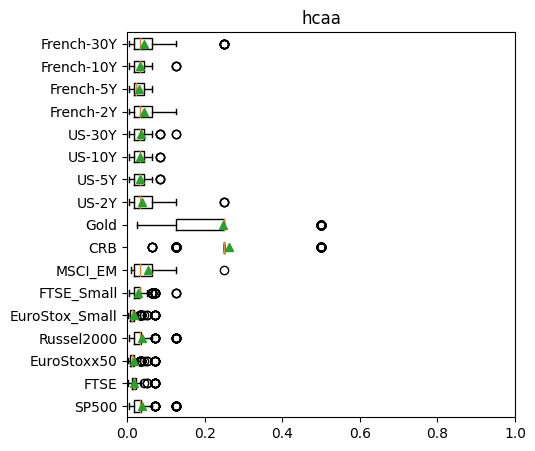

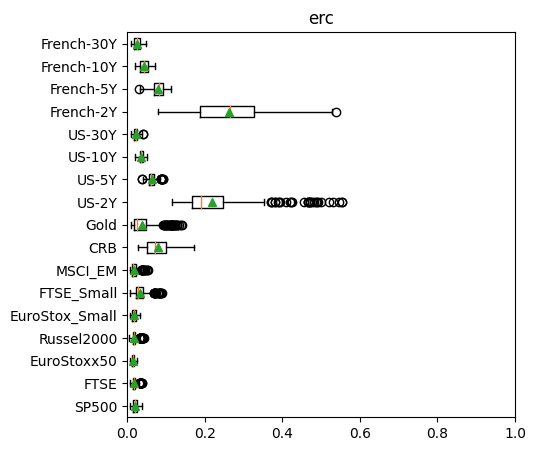

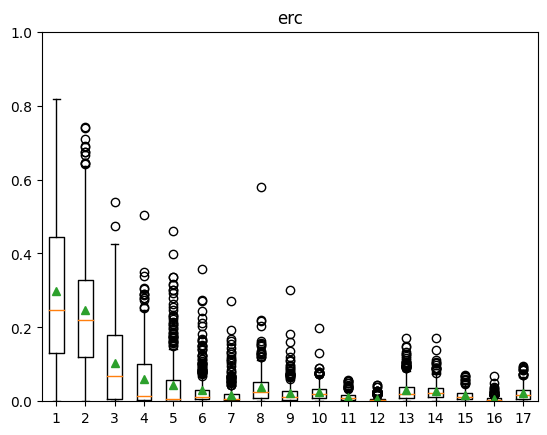

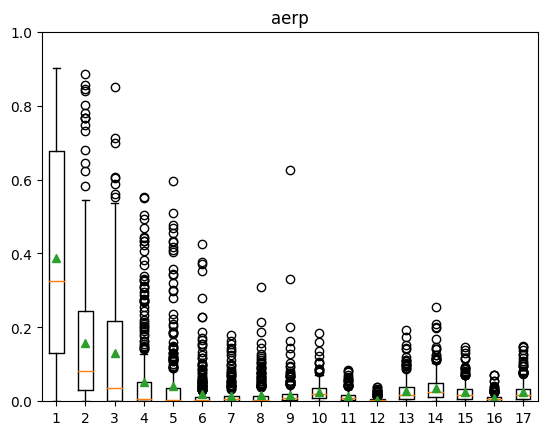

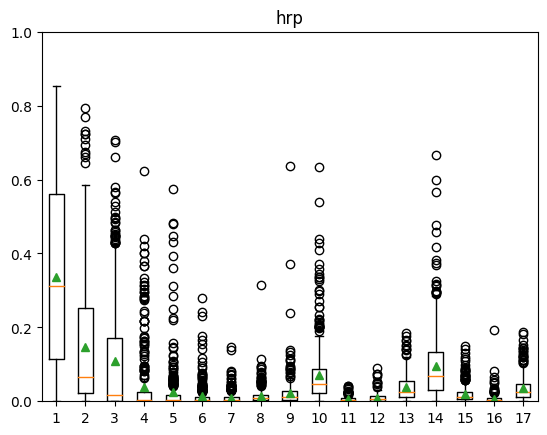

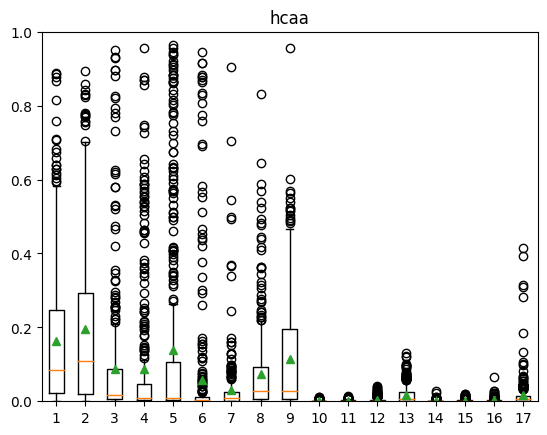

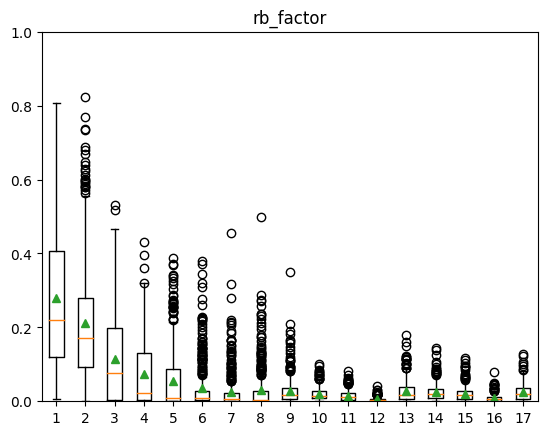

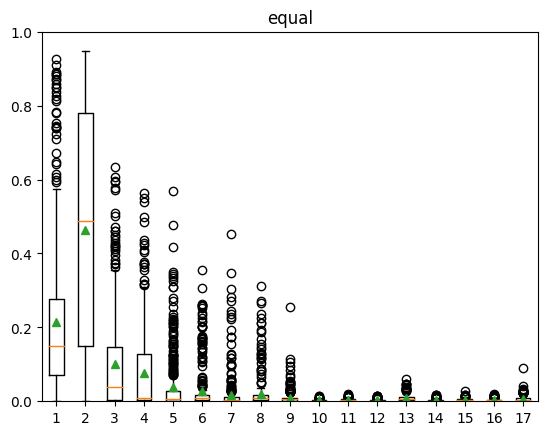

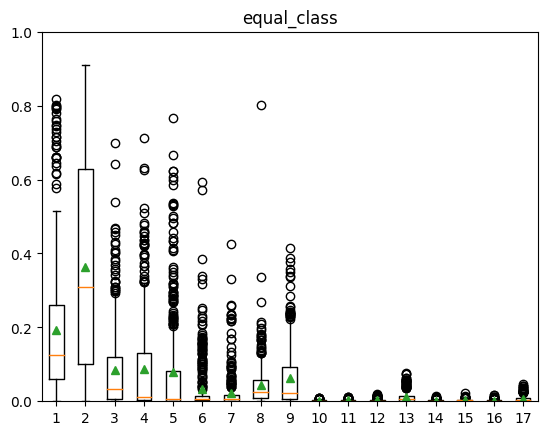

In [124]:
market_budget = pd.read_csv('data/dataset2/market_budget_dataset2.csv', index_col=0)
market_budget['rc'] = market_budget['rc'].astype(int)
cv_results = pd.read_pickle(f"{perf_nmf_dir_2}/cv_results.p")

rc_port, factor_w_port = get_factors_rc_and_weights(cv_results, market_budget, test_set="test")
save=True # SAVE
for p in rc_port.keys():
    if p != "rb_factor_full_erc":
        rc = rc_port[p][0]
        norm_rc = rc.abs() / rc.abs().sum(1).values.reshape(-1, 1)
        plt.boxplot(norm_rc.T, showmeans=True, vert=True)
        plt.ylim(0,1)
        if save:
            plt.savefig(f"{savedir}/factor_rc_{p}_2.png", transparent=True, bbox_inches="tight")
        plt.title(p)
        plt.show()